# Double Machine Learning

## 一、为什么需要DML？

在Robinson（1988）的半参数回归模型中，

主方程：$Y = D \theta_0 + g_0(X) + U, \quad \mathbb{E}[U \mid X, D] = 0$

处理模型：$D = m_0(X) + V, \quad \mathbb{E}[V \mid X] = 0$

其中 $Y$ 是被解释变量，$D$ 是处理变量。这里，我们关注 $\theta$，即处理的因果效应。由于扰动项 $U$ 均值独立于 $D$ 和 $X$，故部分线性模型并无内生性。

传统的参数回归（parametric regression）假设的函数形式已知（例如常见的线性假设），然后直接对主方程进行线性回归估计。但对的函数形式 $g_0(\cdot)$ 很可能误设（misspecified），则会导致偏差，因为根据处理方程，处理变量也依赖于 $X$。

为了避免函数形式误设，经典的半参数回归（Robinson, 1988）使用非参数回归（nonparametric regression）来估计 $\mathbb{E}[Y \mid X]$ 与 $\mathbb{E}[D \mid X]$ 。比如，核回归（kernel regression）或局部线性回归（local linear regression）。但传统的非参数回归由于协变量的维度通常较高，容易遇到“维度诅咒”问题。

对此，很多机器学习的方法在高维数据依然适用，如Lasso、随机森林、梯度提升、神经网络等。但机器学习方法通常有“正则化偏差”（regularization bias），例如以Lasso为代表的惩罚回归（penalized regression）若直接以机器学习方法估计，可能导致偏差。

但是根据上述方法估计 $\hat{g}_0$，随后利用线性回归得到的 ​$\hat{\theta}_0$ 是有偏的：
$$\begin{equation*}
\hat{\theta}_0 = \frac{\mathrm{cov}\left(D, Y - \hat{g}_0(X)\right)}{\mathrm{var}(D)}
= \frac{\frac{1}{n} \sum_{i \in I} D_i \left(Y_i - \hat{g}_0(X_i)\right)}{\frac{1}{n} \sum_{i \in I} D_i^2}
\end{equation*}
$$

$$
\begin{align*}
\sqrt{n}(\hat{\theta}_0 - \theta_0)
&= 
\sqrt{n} \frac{\frac{1}{n} \sum_{i \in I} D_i (Y_i - \hat{g}_0(X_i))}{\frac{1}{n} \sum_{i \in I} D_i^2}
- 
(\sqrt{n} \frac{\frac{1}{n} \sum_{i \in I} D_i (Y_i - g_0(X_i))}{\frac{1}{n} \sum_{i \in I} D_i^2}
- 
\sqrt{n} \frac{\frac{1}{n} \sum_{i \in I} D_i U_i}{\frac{1}{n} \sum_{i \in I} D_i^2}) \\
&= 
\underbrace{
\left( \frac{1}{n} \sum_{i \in I} D_i^2 \right)^{-1} \cdot \left( \frac{1}{\sqrt{n}} \sum_{i \in I} D_i U_i \right)
}_{A}
+ 
\underbrace{
\left( \frac{1}{n} \sum_{i \in I} D_i^2 \right)^{-1} \cdot \left( \frac{1}{\sqrt{n}} \sum_{i \in I} D_i (g_0(X_i) - \hat{g}_0(X_i)) \right)
}_{B}
\end{align*}

$$

可以看出误差分为两项。$A$ 项来自于 $U$ 和 $U$ 的独立性，即$\frac{\mathrm{cov}\left(D, U\right)}{\mathrm{var}(D)}$，若二者不独立则会造成偏误。然而问题来源于 $B$ 项，我们将其展开为以下形式：
$$
B = \left( \mathbb{E}[D_i^2] \right)^{-1} \cdot \frac{1}{n} \sum_{i \in I} m_0(X_i) \left( g_0(X_i) - \hat{g}_0(X_i) \right) + o_P(1)
$$

注意到 $m_0(X_i) \left( g_0(X_i) - \hat{g}_0(X_i) \right)$ 项。首先， ${g}_0$ 的估计往往存在误差，例如对于高维数据，往往会采用正则项处理，造成正则化误差，此时的 $B$ 项发散。此外，$m_0(X_i)$ 是数据本身的性质，因此数据会决定偏误的大小而无法改变，导致估计非常不稳健。综合以上推论，可以说因果模型对于处理效应的传统估计方法并不完美。因此，我们引入双重机器学习的概念，为因果估计提供更稳健的方法。

## 二、DML的本质

根据上述推论，传统因果估计方法不稳健的核心在于  $m_0(X_i) \left( g_0(X_i) - \hat{g}_0(X_i) \right)$ 项，其中 $\left( g_0(X_i) - \hat{g}_0(X_i) \right)$ 部分是${g}_0$ 的估计误差，显然是难以避免的。因此更为实际的考虑是消除 $m_0(X_i)$，其出现原因在于用于回归的 $D$ 实际上包含了 $X$ 的信息。

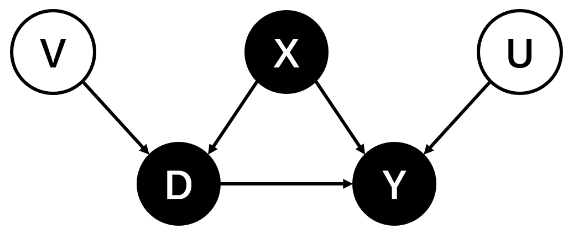

如图，注意到 $V$ 实际上可以看作工具变量，此时可以构造估计：
$$
\theta_0 
= \frac{\operatorname{cov}(V, Y - g_0(X))}{\operatorname{cov}(V, D)}
= \frac{\operatorname{cov}(D - m_0(X), Y - g_0(X))}{\operatorname{cov}(D - m_0(X), D)}
= \frac{\operatorname{cov}(D - m_0(X), D \theta_0 + U)}{\operatorname{cov}(D - m_0(X), D)}
$$


为了求 $V$，可以采用：
$$
\hat V = D - \hat m_0(X)
$$

其中$\hat m_0(X)$ 可以通过 $X$ 对 $D$ 回归得到，因此我们得到一种新的估计：
$$
\hat{\theta}_0 = 
\frac{
\frac{1}{n} \sum_{i \in I} \hat{V}_i \left( Y_i - \hat{g}_0(X_i) \right)
}{
\frac{1}{n} \sum_{i \in I} \hat{V}_i D_i
}
$$

在这个估计下，新的 $B$ 项变为：
$$
b^\ast = \left( \mathbb{E}[D_i^2] \right)^{-1} \cdot \frac{1}{\sqrt{n}} \sum_{i \in I} \left( \hat{m}_0(X_i) - m_0(X_i) \right) \left( g_0(X_i) - \hat{g}_0(X_i) \right)
$$

此时偏误仅仅取决于回归误差，因此这个估计更为稳健。直观角度上，线性回归是拟合 $Y$ 在特征空间 $X$ 的最佳投影，既误差最小化。所以残差垂直于样本空间 $X$，最大限度消除了 $X$ 的相关性。此时我们已经在因果模型中构造了稳健的估计量，我们称这个特征为内曼正交性（Neyman Orthogonality），这种构造就是双重机器学习的思想基础。

## 三、DML的步骤

### Step 1: 估计干扰函数（Nuisance Parameters）
使用机器学习方法分别估计：
$$
\hat{g}(X) \approx \mathbb{E}[Y \mid X], \quad \hat{m}(X) \approx \mathbb{E}[D \mid X]
$$

### Step 2: 残差化（Residualization）
计算残差：
$$
\tilde{Y}_i = Y_i - \hat{g}(X_i), \quad \tilde{D}_i = D_i - \hat{m}(X_i)
$$

### Step 3: 回归残差 (Residual Regression)
使用 OLS 回归：
$$
\tilde{Y}_i = \theta \cdot \tilde{D}_i + \text{noise}
$$
此时估计量 $\hat{\theta}$ 是对因果效应 $\theta_0$ 的估计，并且具有渐近正态性与内曼正交性。

### Step 4: 交叉拟合（Cross-Fitting）
为避免过拟合，将样本分成K折（如5折），在第k折中拟合 $\hat{g}, \hat{m}$ ，并在剩余样本中计算残差与估计 $\hat{\theta}^{(k)}$ 。最终将各折估计结果平均得到：
$$
\hat{\theta} = \frac{1}{K} \sum_{k=1}^{K} \hat{\theta}^{(k)}
$$

## 四、DML实例

### （一）导入工具

In [2]:
# pip install scipy==1.11.4

In [275]:
import pandas as pd
import numpy as np
import logging
import string
import argparse
import gensim
import joblib
import multiprocessing
import nltk
#nltk.download('stopwords')
import joblib
import datetime
import time
import re
import os
import sys

from nltk.corpus import stopwords
#from global_settings import output_paths

In [4]:
all_datasets = ["ipeirotis", "textlab_30", "textlab_10"]

In [5]:
# panel_filename = [x + '_panel.csv' for x in all_datasets]

### （二）分组计算统计量

#### 1、数据处理

In [8]:
# 2014-2016，每六分钟下载一次发布到MTurk平台最新的200个HIT批次，然后每分钟检查每个发现的HIT批次的状态页面，直到页面报告中该批次的所有HIT都被领取。
ipeirotis_panel = pd.read_csv('./data/ipeirotis_panel.csv')
ipeirotis_panel['timestamp'] = pd.to_datetime(ipeirotis_panel['timestamp'])
ipeirotis_panel

,group_id,hits_available,timestamp
0,301G7MYOAJ2BOPC8GAIX74AGQGQ350,1,2016-01-07 16:25:08
1,301G7MYOAJ2BOPC8GAIX74AGQGQ350,0,2016-01-08 15:26:01
2,301G7MYOAJ2FYU5YANHEGT95DZ835P,9,2015-05-23 21:50:08
3,301G7MYOAJ2FYU5YANHEGT95DZ835P,11,2015-05-23 21:55:01
4,301G7MYOAJ2FYU5YANHEGT95DZ835P,0,2015-05-23 22:05:01
...,...,...,...
17608342,ZZAWVTYW3Z9ZTAX43ZD0,25,2016-02-29 14:01:01
17608343,ZZAWVTYW3Z9ZTAX43ZD0,0,2016-02-29 14:38:18
17608344,ZZAWVTYW3Z9ZTAX43ZD0,36,2016-02-29 20:01:00
17608345,ZZAWVTYW3Z9ZTAX43ZD0,0,2016-02-29 20:08:22


In [9]:
# 填充虚假变量
def addFakeObs(df):
    # 检查hits_available是否有所变化
    min_hits = df["hits_available"].min()
    max_hits = df["hits_available"].max()
    no_variation = max_hits == min_hits
    
    last_hits = df["hits_available"].iloc[-1]
    if no_variation and last_hits < 5:
        group_id = df["group_id"].iloc[0]
        # 构造虚假的时间戳
        fake_first = df["timestamp"].iloc[0] - n_mins
        fake_last = df["timestamp"].iloc[-1] + n_mins
        # 填充虚假的时间戳下的变量
        fake_first_df = pd.DataFrame.from_dict({'group_id':[group_id],'hits_available':[0],'timestamp':[fake_first]})
        fake_last_df = pd.DataFrame.from_dict({'group_id':[group_id],'hits_available':[0],'timestamp':[fake_last]})
        # 将原变量与构造的虚假变量连接
        return pd.concat([fake_first_df, df, fake_last_df], ignore_index=True)
    else:
        return df

In [10]:
# 2016.3-2017.8.22 每30分钟在MTutk上记录一次所有HIT批次，从2017年3月开始增加到每10分钟一次。
textlab_30_panel = pd.read_csv('./data/textlab_30_panel.csv', index_col=0).rename({"hit_series":"hits_available","ts_parsed":"timestamp"},axis="columns")
textlab_30_panel['timestamp'] = pd.to_datetime(textlab_30_panel['timestamp'])
n_mins = pd.Timedelta(minutes=30)
textlab_30_panel = textlab_30_panel.groupby("group_id").apply(addFakeObs).reset_index(level=0,drop=True).reset_index(drop=True)
textlab_30_panel

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\183277367.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  textlab_30_panel = textlab_30_panel.groupby("group_id").apply(addFakeObs).reset_index(level=0,drop=True).reset_index(drop=True)


,group_id,hits_available,timestamp
0,00004bd33574f0bbb5415bc39a5e50cd,0,2016-07-06 08:00:00
1,00004bd33574f0bbb5415bc39a5e50cd,1,2016-07-06 08:30:00
2,00004bd33574f0bbb5415bc39a5e50cd,1,2016-07-06 09:00:00
3,00004bd33574f0bbb5415bc39a5e50cd,1,2016-07-06 09:30:00
4,00004bd33574f0bbb5415bc39a5e50cd,1,2016-07-06 10:00:00
...,...,...,...
34098204,ffffc57feb6f5ee5ef5d95a54548bcc5,0,2017-02-23 21:30:00
34098205,ffffc57feb6f5ee5ef5d95a54548bcc5,1,2017-02-23 22:00:00
34098206,ffffc57feb6f5ee5ef5d95a54548bcc5,1,2017-02-23 22:30:00
34098207,ffffc57feb6f5ee5ef5d95a54548bcc5,1,2017-02-23 23:00:00


In [11]:

textlab_10_panel = pd.read_csv('./data/textlab_10_panel.csv', index_col=0).rename({"hit_series":"hits_available","ts_parsed":"timestamp"},axis="columns")
textlab_10_panel['timestamp'] = pd.to_datetime(textlab_10_panel['timestamp'])
n_mins = pd.Timedelta(minutes=10)
textlab_10_panel = textlab_10_panel.groupby("group_id").apply(addFakeObs).reset_index(level=0,drop=True).reset_index(drop=True)
textlab_10_panel

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3590569063.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  textlab_10_panel = textlab_10_panel.groupby("group_id").apply(addFakeObs).reset_index(level=0,drop=True).reset_index(drop=True)


,group_id,hits_available,timestamp
0,301G7MYOAJ1RQHRCTOCVAOHMWTZ35U,0,2017-06-17 18:00:00
1,301G7MYOAJ1RQHRCTOCVAOHMWTZ35U,1,2017-06-17 18:10:00
2,301G7MYOAJ1RQHRCTOCVAOHMWTZ35U,1,2017-06-17 18:20:00
3,301G7MYOAJ1RQHRCTOCVAOHMWTZ35U,1,2017-06-17 18:30:00
4,301G7MYOAJ1RQHRCTOCVAOHMWTZ35U,1,2017-06-17 18:40:00
...,...,...,...
12445363,DVJZW3YZ9Y0MV14JJA5Z,1,2017-08-20 15:10:00
12445364,DVJZW3YZ9Y0MV14JJA5Z,1,2017-08-20 15:20:00
12445365,DVJZW3YZ9Y0MV14JJA5Z,1,2017-08-20 15:30:00
12445366,DVJZW3YZ9Y0MV14JJA5Z,1,2017-08-20 15:40:00


In [12]:
textlab_10_panel[textlab_10_panel['group_id'] == 'DVJZW3YZ9Y0MV14JJA5Z'].iloc[:50]

,group_id,hits_available,timestamp
12445227,DVJZW3YZ9Y0MV14JJA5Z,1,2017-06-01 17:00:00
12445228,DVJZW3YZ9Y0MV14JJA5Z,1,2017-06-01 19:00:00
12445229,DVJZW3YZ9Y0MV14JJA5Z,2,2017-06-02 04:20:00
12445230,DVJZW3YZ9Y0MV14JJA5Z,1,2017-06-02 13:20:00
12445231,DVJZW3YZ9Y0MV14JJA5Z,1,2017-06-03 02:20:00
12445232,DVJZW3YZ9Y0MV14JJA5Z,4,2017-06-03 06:50:00
12445233,DVJZW3YZ9Y0MV14JJA5Z,1,2017-06-03 07:00:00
12445234,DVJZW3YZ9Y0MV14JJA5Z,1,2017-06-03 19:30:00
12445235,DVJZW3YZ9Y0MV14JJA5Z,1,2017-06-04 00:00:00
12445236,DVJZW3YZ9Y0MV14JJA5Z,1,2017-06-04 00:10:00


#### 2、统计量计算

* 最大的hit
* 每组在时间序列下的所有hit
* 第一个hit，最后一个hit
* 时间序列下每组有多少观察值

In [15]:
def computeGroupStats(hits_panel):
    hits_panel.sort_values(by=['group_id','timestamp'],inplace=True)
    hits_panel["hit_diffs"] = hits_panel["hits_available"].diff()
    hits_panel["time_diffs"] = hits_panel["timestamp"].diff()
    # 将变化率调为正值，观察完成率的变化
    hits_panel["hits_completed"] = hits_panel["hit_diffs"].apply(lambda x: -x if x < 0 else np.nan)
    # 每组第一个数值更改为NaN
    mask = hits_panel["group_id"] != hits_panel["group_id"].shift(1)
    hits_panel['hits_completed'][mask] = np.nan
    hits_panel['time_diffs'][mask] = np.nan
    # 零值比较
    hits_panel["is_zero"] = hits_panel["hits_available"].apply(lambda x: int(x == 0.0))
    # 以小时为单位创建时间差向量
    hits_panel["time_diff_hrs"] = hits_panel["time_diffs"] / pd.Timedelta(hours=1)
    # 以分钟为单位创建时间差向量
    hits_panel["time_diff_mins"] = hits_panel["time_diffs"] / pd.Timedelta(minutes=1)
    # 计算每小时hit完成比率
    hits_panel["hits_per_hr"] = hits_panel["hits_completed"] / hits_panel["time_diff_hrs"]

    hit_groups = hits_panel.groupby("group_id")
    ### 开始分组计算统计量
    group_features = []
    # 最大hit数
    max_df = hit_groups["hits_available"].max().rename("max_hits")
    group_features.append(max_df)
    # 最开始的hit数
    first_df = hit_groups["hits_available"].first().rename("first_hits")
    group_features.append(first_df)
    # 最后的hit数
    last_df = hit_groups["hits_available"].last().rename("last_hits")
    group_features.append(last_df)
    # 时间序列中共有多少个观察值
    numobs_df = hit_groups["hits_available"].size().rename("num_obs")
    group_features.append(numobs_df)
    # 每小时变化率均值
    avg_hitrate_df = hit_groups["hits_per_hr"].mean().rename("avg_hitrate")
    # 排除无穷大值找到剩余数值中的最大值，并用最大值替换无穷大值
    noninf_max = avg_hitrate_df[~np.isinf(avg_hitrate_df)].max()
    avg_hitrate_df.replace(np.inf, noninf_max, inplace=True)
    group_features.append(avg_hitrate_df)
    # 完成率均值
    avg_hits_completed = hit_groups["hits_completed"].mean().rename("avg_hits_completed")
    group_features.append(avg_hits_completed)
    # 完成率中位数
    med_hits_completed = hit_groups["hits_completed"].median().rename("med_hits_completed")
    group_features.append(med_hits_completed)
    # 完成率最小值
    min_hits_completed = hit_groups["hits_completed"].min().rename("min_hits_completed")
    group_features.append(min_hits_completed)
    # M完成率最大值
    max_hits_completed = hit_groups["hits_completed"].max().rename("max_hits_completed")
    group_features.append(max_hits_completed)
    # 完成率标准差
    hits_completed_sd = hit_groups["hits_completed"].std().rename("hits_completed_sd")
    group_features.append(hits_completed_sd)

    # 记录开始时间
    firsttime_df = hit_groups["timestamp"].first().rename("first_time")
    group_features.append(firsttime_df)
    # 记录结束时间
    lasttime_df = hit_groups["timestamp"].last().rename("last_time")
    group_features.append(lasttime_df)

    ### 计算时间差向量特征
    # 平均值
    avg_time_gap = hit_groups["time_diff_mins"].mean().rename("avg_time_gap")
    group_features.append(avg_time_gap)
    # 中位数
    med_time_gap = hit_groups["time_diff_mins"].median().rename("med_time_gap")
    group_features.append(med_time_gap)
    # 最小值
    min_time_gap = hit_groups["time_diff_mins"].min().rename("min_time_gap")
    group_features.append(min_time_gap)
    # 最大值
    max_time_gap = hit_groups["time_diff_mins"].max().rename("max_time_gap")
    group_features.append(max_time_gap)
    # 标准差
    time_gap_sd = hit_groups["time_diff_mins"].std().rename("time_gap_sd")
    group_features.append(time_gap_sd)

    # 0值的数量
    numzeros_df = hit_groups["is_zero"].sum().rename("num_zeros")
    group_features.append(numzeros_df)

    # 将所有统计量打包进group_level
    group_level = pd.concat(group_features,axis=1)

    # 计算持续期
    group_level["duration"] = group_level["last_time"] - group_level["first_time"]
    group_level['duration'] = group_level['duration'] / np.timedelta64(1, 'm')
    #group_level["duration"] = group_level["duration"].astype('timedelta64[s]')
    #group_level["duration"] = group_level["duration"].astype('timedelta64[m]')

    return group_level

In [16]:
group_level_textlab10 = computeGroupStats(textlab_10_panel)
group_level_textlab10.to_pickle('./data/textlab_10_group_stats.pkl')
group_level_textlab10.to_csv('./data/textlab_10_group_stats.csv')

group_level_textlab30 = computeGroupStats(textlab_30_panel)
group_level_textlab30.to_pickle('./data/textlab_30_group_stats.pkl')
group_level_textlab30.to_csv('./data/textlab_30_group_stats.csv')

group_level_ipeirotis = computeGroupStats(ipeirotis_panel)
group_level_ipeirotis.to_pickle('./data/ipeirotis_group_stats.pkl')
group_level_ipeirotis.to_csv('./data/ipeirotis_group_stats.csv')

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\643954037.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hits_panel['hits_completed'][mask] = np.nan
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\643954037.py:9: SettingWith

In [17]:
ipeirotis_meta = pd.read_csv('./data/ipeirotis_meta.csv', index_col=0)
requester_vars = ["group_id","requester_id","title","description","keywords",
                         "time_allotted","reward","qualifications","expiration_date"]
print("requester data length: " + str(len(ipeirotis_meta)))
print("unique group_ids in requester data: " + str(len(ipeirotis_meta["group_id"].value_counts())))
ipeirotis_meta.set_index('group_id', inplace=True)
merged_df_ipeirotis = group_level_ipeirotis.merge(ipeirotis_meta, left_index=True, right_index=True, indicator=True)
# 检验合并是否正确，indicator在DataFrame最后会生成一个_merge来说明该行数据来源于哪个表格，二者都有标记为both，否则为left_only,right_only
num_badmerge = sum(merged_df_ipeirotis["_merge"] != "both")
if num_badmerge > 0:
        print("Bad merge!!")
merged_df_ipeirotis.drop(columns="_merge",inplace=True)
merged_df_ipeirotis.to_csv('./data/ipeirotis_group.csv')
merged_df_ipeirotis.to_pickle('./data/ipeirotis_group.pkl')
merged_df_ipeirotis

requester data length: 411196
unique group_ids in requester data: 411196


,max_hits,first_hits,last_hits,num_obs,avg_hitrate,avg_hits_completed,med_hits_completed,min_hits_completed,max_hits_completed,hits_completed_sd,...,time_allotted,kind,reward,qualifications,first_seen,last_seen,expiration_date,duration_old,log_duration_old,log_reward
group_id,,,,,,,,,,,,,,,,,,,,,
301G7MYOAJ2BOPC8GAIX74AGQGQ350,1,1,0,2,0.043450,1.000000,1.0,1.0,1.0,NaN,...,3600,mturk#hitgroupItem,55,"['Total approved HITs is not less than 100', '...",2016-01-07 16:25:08,2016-01-08 15:21:00,2016-01-27T00:00:00.000Z,1375.0,7.226209,4.007333
301G7MYOAJ2FYU5YANHEGT95DZ835P,11,9,0,3,66.000000,11.000000,11.0,11.0,11.0,NaN,...,3600,mturk#hitgroupItem,1,NaN,2015-05-23 21:50:08,2015-05-23 22:00:02,2015-05-27T00:00:00.000Z,9.0,2.197225,0.000000
301G7MYOAJ2GKVIZE6OLR130JML53R,1,1,0,2,0.007929,1.000000,1.0,1.0,1.0,NaN,...,1200,mturk#hitgroupItem,50,NaN,2014-06-16 21:24:45,2014-06-22 03:26:40,2014-08-25T00:00:00.000Z,7561.0,8.930759,3.912023
301G7MYOAJ2YU4YTD9HY8W55XQD356,1,1,0,4,0.092967,1.000000,1.0,1.0,1.0,0.000000,...,3600,mturk#hitgroupItem,50,NaN,2014-10-01 12:07:38,2014-10-22 03:41:33,2014-11-04T00:00:00.000Z,29733.0,10.300013,3.912023
301G7MYOAJ2YU4YTD9HY8W57OW9359,1,1,0,60,15.906404,1.000000,1.0,1.0,1.0,0.000000,...,2400,mturk#hitgroupItem,200,['Location is US'],2015-10-13 17:02:18,2015-10-25 21:01:08,2015-10-25T00:00:00.000Z,17518.0,9.770984,5.298317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4YFZK2ZCCXSZ64ZJNTR0,271,176,0,8,533.747917,45.166667,41.0,18.0,88.0,23.016661,...,1200,mturk#hitgroupItem,5,NaN,2014-09-08 17:45:33,2014-09-08 18:15:21,2014-09-10T00:00:00.000Z,29.0,3.367296,1.609438
DVJZW3YZ9Y0MV14JJA5Z,190,1,1,34680,16.132259,1.290898,1.0,1.0,90.0,1.265982,...,480,mturk#hitgroupItem,5,['HIT approval rate (%) is greater than 95'],2014-05-02 08:25:17,2016-07-16 20:19:12,2016-04-04T00:00:00.000Z,1161353.0,13.965096,1.609438
J1ZZNQGNTW1YZVD8FWTZ,5474,64,0,1934,37.801095,4.099866,3.0,1.0,782.0,20.336540,...,3600,mturk#hitgroupItem,5,NaN,2014-09-15 15:13:09,2014-09-29 15:19:57,2014-09-29T00:00:00.000Z,20166.0,9.911753,1.609438


In [18]:
textlab_30_meta = pd.read_csv('./data/textlab_30_meta.csv')
requester_vars = ["group_id","requester_id","title","requester","expiration_date",
                         "reward","time_allotted","time_left"]

print("requester data length: " + str(len(textlab_30_meta)))
print("unique group_ids in requester data: " + str(len(textlab_30_meta["group_id"].value_counts())))
textlab_30_meta.set_index('group_id', inplace=True)
merged_df_textlab30 = group_level_textlab30.merge(textlab_30_meta, left_index=True, right_index=True, indicator=True)
# 检验合并是否正确，indicator在DataFrame最后会生成一个_merge来说明该行数据来源于哪个表格，二者都有标记为both，否则为left_only,right_only
num_badmerge = sum(merged_df_textlab30["_merge"] != "both")
if num_badmerge > 0:
        print("Bad merge!!")
merged_df_textlab30.drop(columns="_merge",inplace=True)
merged_df_textlab30.to_csv('./data/textlab_30_group.csv')
merged_df_textlab30.to_pickle('./data/textlab_30_group.pkl')
merged_df_textlab30

requester data length: 363167
unique group_ids in requester data: 363167


,max_hits,first_hits,last_hits,num_obs,avg_hitrate,avg_hits_completed,med_hits_completed,min_hits_completed,max_hits_completed,hits_completed_sd,...,num_zeros,duration,requester_id,title,requester,expiration_date,hit_info_str,reward,time_allotted,time_left
group_id,,,,,,,,,,,,,,,,,,,,,
00004bd33574f0bbb5415bc39a5e50cd,1,0,0,63,2.000000,1.000000,1.0,1.0,1.0,NaN,...,2,1890.0,A1DIWKR9NEY82N,Change Sciences Missed Submission,Change Sciences Group,"Jul 7, 2016",A1DIWKR9NEY82N|$1.50|Change Sciences Missed Su...,$1.50,60 minutes,23 hours 37 minutes
000057992d4dccafb2c5481d655ae2e5,1,0,0,9,2.000000,1.000000,1.0,1.0,1.0,NaN,...,2,240.0,A1AQ7EJ5P7ME65,Urgent - Higher Pay - Review media transcripti...,Speechpad,"Oct 12, 2016",A1AQ7EJ5P7ME65|$1.75|Urgent - Higher Pay - Rev...,$1.75,60 minutes,6 days 23 hours
0000990eeaa355136a2ef1bdc9b1484a,65,53,65,12,2.666667,1.333333,1.0,1.0,2.0,0.57735,...,0,330.0,A3RXXNTGSUSTQ9,Labeling Tweets 24,Siddharth Suri,"Aug 22, 2016",A3RXXNTGSUSTQ9|$0.10|Labeling Tweets 24,$0.10,5 minutes,5 hours 34 minutes
0000f33788d8874bec0c72d6bdb73924,1,0,0,7,2.000000,1.000000,1.0,1.0,1.0,NaN,...,2,180.0,A1AQ7EJ5P7ME65,Urgent - Higher Pay - Review media transcripti...,Speechpad,"Aug 26, 2016",A1AQ7EJ5P7ME65|$0.41|Urgent - Higher Pay - Rev...,$0.41,60 minutes,6 days 23 hours
00011eb8afef8299e0e2ad1886808edc,1,0,0,3,2.000000,1.000000,1.0,1.0,1.0,NaN,...,2,60.0,A3MX44TDYCA6JW,26Retrieve Property Numbers 2016 ML 12.007,Obsidian,"Jan 19, 2017",A3MX44TDYCA6JW|$0.07|26Retrieve Property Numbe...,$0.07,7 minutes,2 hours 30 minutes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff88efcc2a740c51bbe0723685d9d6,1,0,0,25,2.000000,1.000000,1.0,1.0,1.0,NaN,...,2,750.0,A1AQ7EJ5P7ME65,Transcribe Audio A2488742 (Audio length: 34 ...,Speechpad,"Jul 21, 2016",A1AQ7EJ5P7ME65|$7.67|Transcribe Audio A248874...,$7.67,5 hours 6 minutes,6 days 23 hours
ffff9f464f1e1d0a8c9e8588ce435e5e,1,0,0,172,2.000000,1.000000,1.0,1.0,1.0,NaN,...,2,5220.0,A2883M4WUQRXJ1,Converse with Mobile Weather App,MTurkIRL,"Mar 16, 2017",A2883M4WUQRXJ1|$0.15|Converse with Mobile Weat...,$0.15,10 minutes,6 days 23 hours
ffffa737ffbf5907be129d98f9823fe8,1,0,0,104,2.000000,1.000000,1.0,1.0,1.0,NaN,...,2,4140.0,A1AQ7EJ5P7ME65,Transcribe Audio A2482487 (Audio length: 36 ...,Speechpad,"Jun 23, 2016",A1AQ7EJ5P7ME65|$8.29|Transcribe Audio A248248...,$8.29,4 hours 54 minutes,6 days 23 hours


In [19]:
textlab_10_meta = pd.read_csv('./data/textlab_10_meta.csv')
requester_vars = ["group_id","reward","time_left","requester","time_allotted","title",
                            "keywords","requester_id","description","expiration_date"]
print("requester data length: " + str(len(textlab_10_meta)))
print("unique group_ids in requester data: " + str(len(textlab_10_meta["group_id"].value_counts())))
textlab_10_meta.set_index('group_id', inplace=True)
merged_df_textlab10 = group_level_textlab10.merge(textlab_10_meta, left_index=True, right_index=True, indicator=True)
# 检验合并是否正确，indicator在DataFrame最后会生成一个_merge来说明该行数据来源于哪个表格，二者都有标记为both，否则为left_only,right_only
num_badmerge = sum(merged_df_textlab10["_merge"] != "both")
if num_badmerge > 0:
        print("Bad merge!!")
merged_df_textlab10.drop(columns="_merge",inplace=True)
merged_df_textlab10.to_csv('./data/textlab_10_group.csv')
merged_df_textlab10.to_pickle('./data/textlab_10_group.pkl')
merged_df_textlab10

requester data length: 110313
unique group_ids in requester data: 110313


,max_hits,first_hits,last_hits,num_obs,avg_hitrate,avg_hits_completed,med_hits_completed,min_hits_completed,max_hits_completed,hits_completed_sd,...,duration,reward,time_left,requester,time_allotted,title,keywords,requester_id,description,expiration_date
group_id,,,,,,,,,,,,,,,,,,,,,
301G7MYOAJ1RQHRCTOCVAOHMWTZ35U,1,0,0,10,6.000000,1.000000,1.0,1.0,1.0,NaN,...,90.0,$0.15,6 days 23 hours,Zhenglin Liu,30 minutes,Recycling Attitudes and Intentions Questionnaire,survey|recycling|opinions,A2R9VUC7LO7HJU,Complete a questionnaire related to waste recy...,"Jun 24, 2017"
301G7MYOAJ397EAIS94FMNLGU7035W,1,0,0,4,6.000000,1.000000,1.0,1.0,1.0,NaN,...,410.0,$0.03,2 hours 43 minutes,Fred Vollmer,2 minutes,Image Annotation Verification,image annotation|image tagging|directions|navi...,A1W518UWEFCTSE,Verify that the description of an image is acc...,"Jun 7, 2017"
301G7MYOAJ39FPP8WA9R6K95M9335Z,1,0,0,22,6.000000,1.000000,1.0,1.0,1.0,NaN,...,210.0,$0.70,1 week 6 days,Ina Garnefeld,15 minutes,Consumer survey about sales promotions,Sales promotions|consumer survey|academic study,A39EQL8PB8SVTQ,Academic study interested in customer feelings...,"Aug 25, 2017"
301G7MYOAJ3OHAOZV8UWUP9UZHM53Y,1,0,0,5,6.000000,1.000000,1.0,1.0,1.0,NaN,...,40.0,$0.75,2 weeks 5 days,UW Psychology and Law,50 minutes,Investigation of Attitudes Towards Groups(~ 25...,survey|demographics,A2FS313FG0JGW3,You will be asked to complete a variety of que...,"Jul 4, 2017"
301G7MYOAJ54ES5MA4KIU09DOJ653Q,1,0,0,3,6.000000,1.000000,1.0,1.0,1.0,NaN,...,20.0,$0.20,4 weeks 1 day,A.M.,60 minutes,Quick Interesting Survey: Social attitudes(~ 2...,quick survey|short survey|opinions|attitudes|b...,A79USK145OBJJ,This is a quick 2 minute survey on your attitudes,"Jul 20, 2017"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3ZY19HV01BONLIR1KK5SXUJQHSIGS3,1,0,0,17,6.000000,1.000000,1.0,1.0,1.0,NaN,...,14720.0,$0.52,23 hours 51 minutes,Foxtrot,26 minutes,Copy Edit English Text,grammatical error correction|proofreading|revi...,A3AYV6BR7VCGW0,Proofreading English Text: Correct spelling a...,"Jul 11, 2017"
3ZY19HV01BONLIR1KK5SXUJQIWEGS8,1,0,0,31,6.000000,1.000000,1.0,1.0,1.0,NaN,...,19640.0,$0.78,23 hours 46 minutes,Foxtrot,39 minutes,Copy Edit English Text,grammatical error correction|proofreading|revi...,A3AYV6BR7VCGW0,Proofreading English Text: Correct spelling a...,"Aug 1, 2017"
3ZY19HV01BPM76GKCNBV9R7GD76SG1,1,0,0,248,6.000000,1.000000,1.0,1.0,1.0,NaN,...,5930.0,$0.10,1 day 11 hours,Oregon Researcher,60 minutes,What Are People Thinking? - 2 Minute Survey,survey|demographics|articles|reading|opinion,A3JG43JLET2NUM,What are people think. 2 minute survey on topi...,"Jul 27, 2017"


#### 3、清洗数据

In [21]:
def cleanGroupData(hit_df, data_name):
    if data_name == 'textlab_10' or data_name == 'textlab_30':
        hit_df["reward"] = hit_df["reward"].str.replace("$","").astype(float) * 100
    ## 取对数值
    hit_df["log_reward"] = hit_df["reward"].apply(np.log)
    hit_df["log_duration"] = hit_df["duration"].apply(np.log)
    ## 记录有效观测值（最后的hit数小于最开始的hit数）（仅针对ipeirotis数据）
    if data_name == "ipeirotis":
        hit_df["valid_duration"] = hit_df["last_hits"] <= hit_df["first_hits"]
    else:
        hit_df["valid_duration"] = 1
    print("Invalid durations marked")

    # 去掉 rewards/durations 为null的数据
    print("# null log_reward: " + str(len(np.where(hit_df["log_reward"].isnull())[0])))# 返回空值的行索引
    print("# null log_duration: " + str(len(np.where(hit_df["log_duration"].isnull())[0])))
    print("Total number of obs: " + str(len(hit_df)))
    hit_df["log_duration"] = hit_df["log_duration"].replace(-np.inf, np.nan)
    hit_df["log_reward"] = hit_df["log_reward"].replace(-np.inf, np.nan)
    hit_df = hit_df.dropna(subset=["log_duration"])
    hit_df = hit_df.dropna(subset=["log_reward"])
    # 去掉空值后的观测值数量
    print("New # observations after dropping null rewards/durations: " + str(len(hit_df)))

    ## 去掉无效的观测期间
    hit_df = hit_df[hit_df["valid_duration"] == 1]
    hit_df = hit_df[hit_df["duration"] > 0]
    print("Number of HIT batches once invalid durations are dropped: " + str(len(hit_df.index)))
    ## 去掉无效的报酬
    hit_df = hit_df[~hit_df["log_reward"].isnull()]
    print("And once invalid rewards are dropped: " + str(len(hit_df.index)))

    # 筛出异常值
    #rew_upper_cutoff = hit_df["reward"].quantile(0.995)
    rew_upper_cutoff = 500.0
    #dur_upper_cutoff = hit_df["duration_new"].quantile(0.995)
    dur_upper_cutoff = 90000.0
    print("Dropping obs with reward < 0 or reward > " + str(rew_upper_cutoff))
    print("Dropping obs with duration_new < 0 or duration_new > " + str(dur_upper_cutoff))
    hit_df = hit_df[(hit_df["duration"] > 0) & (hit_df["duration"] < dur_upper_cutoff)]
    hit_df = hit_df[(hit_df["reward"] > 0) & (hit_df["reward"] < rew_upper_cutoff)]
    print("Number of obs remaining: " + str(len(hit_df.index)))

    ## Description and title 可以直接使用, 但是 keywords 需要在 ipeirotis+textlab_10 中进一步解析
    if data_name == "ipeirotis":
        keyword_reg = r'\'(\S+)\''
        hit_df["kw_parsed"] = hit_df["keywords"].apply(lambda x: ' '.join(re.findall(keyword_reg, x)) if pd.notnull(x) else '')
    elif data_name == "textlab_10":
        hit_df["kw_parsed"] = hit_df["keywords"].str.replace('|',' ')
        hit_df["kw_parsed"] = hit_df["kw_parsed"].str.replace('nan','')
        hit_df["kw_parsed"] = hit_df["kw_parsed"].astype(str)

    ## Ipeirotis 数据保留至2016.2.1
    if data_name == "ipeirotis":
        feb1 = datetime.datetime(2016,2,1)
        hit_df = hit_df[hit_df["last_time"] < feb1]
        print("Number of obs after dropping Feb 1 onwards: " + str(len(hit_df)))

    ## 将如 "30 minutes" 这样的字符串时间数据转换为整型
    min_reg = r'([0-9]+) (?:minute)|(?:minutes)'
    hr_reg = r'([0-9]+) (?:hour)|(?:hours)'
    day_reg = r'([0-9]+) (?:day)|(?:days)'
    week_reg = r'([0-9]+) (?:week)|(?:weeks)'

    def convertToMins(cur_time):
        if type(cur_time) == int:
            return cur_time
        total_mins = 0
        # 分钟
        min_match = re.findall(min_reg, cur_time)
        num_mins = int(min_match[0]) if min_match else 0
        total_mins += num_mins
        # 小时
        hr_match = re.findall(hr_reg, cur_time)
        num_hrs = int(hr_match[0]) if hr_match else 0
        total_mins += 60*num_hrs
        # 天
        day_match = re.findall(day_reg, cur_time)
        num_days = int(day_match[0]) if day_match else 0
        total_mins += 60*24*num_days
        # 周
        week_match = re.findall(week_reg, cur_time)
        num_weeks = int(week_match[0]) if week_match else 0
        total_mins += 60*24*7*num_weeks
        return total_mins

    if data_name == "textlab_10" or data_name == "textlab_30":
        hit_df["time_allotted"] = hit_df["time_allotted"].apply(convertToMins)

    return hit_df

In [22]:
ipeirotis_cleaned = cleanGroupData(merged_df_ipeirotis, 'ipeirotis')
ipeirotis_cleaned.to_pickle('./data/ipeirotis_cleaned.pkl')
ipeirotis_cleaned

Invalid durations marked
# null log_reward: 11
# null log_duration: 0
Total number of obs: 410284
New # observations after dropping null rewards/durations: 304662
Number of HIT batches once invalid durations are dropped: 303858
And once invalid rewards are dropped: 303858
Dropping obs with reward < 0 or reward > 500.0
Dropping obs with duration_new < 0 or duration_new > 90000.0
Number of obs remaining: 285327
Number of obs after dropping Feb 1 onwards: 259502


,max_hits,first_hits,last_hits,num_obs,avg_hitrate,avg_hits_completed,med_hits_completed,min_hits_completed,max_hits_completed,hits_completed_sd,...,qualifications,first_seen,last_seen,expiration_date,duration_old,log_duration_old,log_reward,log_duration,valid_duration,kw_parsed
group_id,,,,,,,,,,,,,,,,,,,,,
301G7MYOAJ2BOPC8GAIX74AGQGQ350,1,1,0,2,0.043450,1.000000,1.0,1.0,1.0,NaN,...,"['Total approved HITs is not less than 100', '...",2016-01-07 16:25:08,2016-01-08 15:21:00,2016-01-27T00:00:00.000Z,1375.0,7.226209,4.007333,7.230479,True,politics
301G7MYOAJ2FYU5YANHEGT95DZ835P,11,9,0,3,66.000000,11.000000,11.0,11.0,11.0,NaN,...,NaN,2015-05-23 21:50:08,2015-05-23 22:00:02,2015-05-27T00:00:00.000Z,9.0,2.197225,0.000000,2.700242,True,categorize
301G7MYOAJ2GKVIZE6OLR130JML53R,1,1,0,2,0.007929,1.000000,1.0,1.0,1.0,NaN,...,NaN,2014-06-16 21:24:45,2014-06-22 03:26:40,2014-08-25T00:00:00.000Z,7561.0,8.930759,3.912023,8.931548,True,survey personality stress rating
301G7MYOAJ2YU4YTD9HY8W55XQD356,1,1,0,4,0.092967,1.000000,1.0,1.0,1.0,0.000000,...,NaN,2014-10-01 12:07:38,2014-10-22 03:41:33,2014-11-04T00:00:00.000Z,29733.0,10.300013,3.912023,10.300216,True,survey brief short situation
301G7MYOAJ2YU4YTD9HY8W57OW9359,1,1,0,60,15.906404,1.000000,1.0,1.0,1.0,0.000000,...,['Location is US'],2015-10-13 17:02:18,2015-10-25 21:01:08,2015-10-25T00:00:00.000Z,17518.0,9.770984,5.298317,9.771196,True,decisions online reward bonus fun interesting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3ZY19HV01BIMKUJC8R23XWPE2U4GSE,1,1,0,2,0.039658,1.000000,1.0,1.0,1.0,NaN,...,['HIT approval rate (%) is not less than 90'],2015-10-25 01:22:08,2015-10-26 02:30:03,2015-10-26T00:00:00.000Z,1507.0,7.317876,1.609438,7.321806,True,feedback image interface UI design easy
3ZY19HV01BIUAL70JGMVTT0E150GSD,1,1,0,6,9.107489,1.000000,1.0,1.0,1.0,0.000000,...,"['Total approved HITs is not less than 50', 'H...",2015-10-19 17:14:05,2015-10-19 17:44:52,2015-10-21T00:00:00.000Z,30.0,3.401197,3.688879,3.577016,True,survey demographics
3ZY19HV01BMN1HMYRKAG7N9SYLVGSY,1,1,0,2,0.151299,1.000000,1.0,1.0,1.0,NaN,...,['Masters has been granted none Request Qualif...,2016-01-05 12:40:03,2016-01-05 19:11:34,2016-01-08T00:00:00.000Z,391.0,5.968708,2.708050,5.982844,True,psychology


In [23]:
textlab_30_cleaned = cleanGroupData(merged_df_textlab30, 'textlab_30')
textlab_30_cleaned.to_pickle('./data/textlab_30_cleaned.pkl')
textlab_30_cleaned

Invalid durations marked
# null log_reward: 0
# null log_duration: 0
Total number of obs: 363167
New # observations after dropping null rewards/durations: 355469
Number of HIT batches once invalid durations are dropped: 355469
And once invalid rewards are dropped: 355469
Dropping obs with reward < 0 or reward > 500.0
Dropping obs with duration_new < 0 or duration_new > 90000.0
Number of obs remaining: 292746


,max_hits,first_hits,last_hits,num_obs,avg_hitrate,avg_hits_completed,med_hits_completed,min_hits_completed,max_hits_completed,hits_completed_sd,...,title,requester,expiration_date,hit_info_str,reward,time_allotted,time_left,log_reward,log_duration,valid_duration
group_id,,,,,,,,,,,,,,,,,,,,,
00004bd33574f0bbb5415bc39a5e50cd,1,0,0,63,2.000000,1.000000,1.0,1.0,1.0,NaN,...,Change Sciences Missed Submission,Change Sciences Group,"Jul 7, 2016",A1DIWKR9NEY82N|$1.50|Change Sciences Missed Su...,150.0,60,23 hours 37 minutes,5.010635,7.544332,1
000057992d4dccafb2c5481d655ae2e5,1,0,0,9,2.000000,1.000000,1.0,1.0,1.0,NaN,...,Urgent - Higher Pay - Review media transcripti...,Speechpad,"Oct 12, 2016",A1AQ7EJ5P7ME65|$1.75|Urgent - Higher Pay - Rev...,175.0,60,6 days 23 hours,5.164786,5.480639,1
0000990eeaa355136a2ef1bdc9b1484a,65,53,65,12,2.666667,1.333333,1.0,1.0,2.0,0.57735,...,Labeling Tweets 24,Siddharth Suri,"Aug 22, 2016",A3RXXNTGSUSTQ9|$0.10|Labeling Tweets 24,10.0,5,5 hours 34 minutes,2.302585,5.799093,1
0000f33788d8874bec0c72d6bdb73924,1,0,0,7,2.000000,1.000000,1.0,1.0,1.0,NaN,...,Urgent - Higher Pay - Review media transcripti...,Speechpad,"Aug 26, 2016",A1AQ7EJ5P7ME65|$0.41|Urgent - Higher Pay - Rev...,41.0,60,6 days 23 hours,3.713572,5.192957,1
00011eb8afef8299e0e2ad1886808edc,1,0,0,3,2.000000,1.000000,1.0,1.0,1.0,NaN,...,26Retrieve Property Numbers 2016 ML 12.007,Obsidian,"Jan 19, 2017",A3MX44TDYCA6JW|$0.07|26Retrieve Property Numbe...,7.0,7,2 hours 30 minutes,1.945910,4.094345,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffdae03eb029f2d8e60eabaa971adc2,1,0,0,9,2.000000,1.000000,1.0,1.0,1.0,NaN,...,Transcribe on-line orders A2540323 (Audio le...,Speechpad,"Feb 3, 2017",A1AQ7EJ5P7ME65|$0.02|Transcribe on-line orders...,2.0,60,6 days 23 hours,0.693147,5.480639,1
ffff1d8b216a25a0619474b6a465dde5,1,0,0,4,2.000000,1.000000,1.0,1.0,1.0,NaN,...,Urgent - Higher Pay - Review media transcripti...,Speechpad,"Mar 16, 2017",A1AQ7EJ5P7ME65|$3.69|Urgent - Higher Pay - Rev...,369.0,60,6 days 23 hours,5.910797,4.787492,1
ffff9f464f1e1d0a8c9e8588ce435e5e,1,0,0,172,2.000000,1.000000,1.0,1.0,1.0,NaN,...,Converse with Mobile Weather App,MTurkIRL,"Mar 16, 2017",A2883M4WUQRXJ1|$0.15|Converse with Mobile Weat...,15.0,10,6 days 23 hours,2.708050,8.560253,1


In [24]:
textlab_10_cleaned = cleanGroupData(merged_df_textlab10, 'textlab_10')
textlab_10_cleaned.to_pickle('./data/textlab_10_cleaned.pkl')
textlab_10_cleaned

Invalid durations marked
# null log_reward: 0
# null log_duration: 0
Total number of obs: 110313
New # observations after dropping null rewards/durations: 107930
Number of HIT batches once invalid durations are dropped: 107930
And once invalid rewards are dropped: 107930
Dropping obs with reward < 0 or reward > 500.0
Dropping obs with duration_new < 0 or duration_new > 90000.0
Number of obs remaining: 93775


,max_hits,first_hits,last_hits,num_obs,avg_hitrate,avg_hits_completed,med_hits_completed,min_hits_completed,max_hits_completed,hits_completed_sd,...,time_allotted,title,keywords,requester_id,description,expiration_date,log_reward,log_duration,valid_duration,kw_parsed
group_id,,,,,,,,,,,,,,,,,,,,,
301G7MYOAJ1RQHRCTOCVAOHMWTZ35U,1,0,0,10,6.0,1.0,1.0,1.0,1.0,NaN,...,30,Recycling Attitudes and Intentions Questionnaire,survey|recycling|opinions,A2R9VUC7LO7HJU,Complete a questionnaire related to waste recy...,"Jun 24, 2017",2.708050,4.499810,1,survey recycling opinions
301G7MYOAJ397EAIS94FMNLGU7035W,1,0,0,4,6.0,1.0,1.0,1.0,1.0,NaN,...,2,Image Annotation Verification,image annotation|image tagging|directions|navi...,A1W518UWEFCTSE,Verify that the description of an image is acc...,"Jun 7, 2017",1.098612,6.016157,1,image annotation image tagging directions navi...
301G7MYOAJ39FPP8WA9R6K95M9335Z,1,0,0,22,6.0,1.0,1.0,1.0,1.0,NaN,...,15,Consumer survey about sales promotions,Sales promotions|consumer survey|academic study,A39EQL8PB8SVTQ,Academic study interested in customer feelings...,"Aug 25, 2017",4.248495,5.347108,1,Sales promotions consumer survey academic study
301G7MYOAJ3OHAOZV8UWUP9UZHM53Y,1,0,0,5,6.0,1.0,1.0,1.0,1.0,NaN,...,50,Investigation of Attitudes Towards Groups(~ 25...,survey|demographics,A2FS313FG0JGW3,You will be asked to complete a variety of que...,"Jul 4, 2017",4.317488,3.688879,1,survey demographics
301G7MYOAJ54ES5MA4KIU09DOJ653Q,1,0,0,3,6.0,1.0,1.0,1.0,1.0,NaN,...,60,Quick Interesting Survey: Social attitudes(~ 2...,quick survey|short survey|opinions|attitudes|b...,A79USK145OBJJ,This is a quick 2 minute survey on your attitudes,"Jul 20, 2017",2.995732,2.995732,1,quick survey short survey opinions attitudes b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3ZY19HV01BONLIR1KK5SXUJQHSGGS1,1,0,0,20,6.0,1.0,1.0,1.0,1.0,NaN,...,22,Copy Edit English Text,grammatical error correction|proofreading|revi...,A3AYV6BR7VCGW0,Proofreading English Text: Correct spelling a...,"Jul 9, 2017",3.784190,11.017809,1,grammatical error correction proofreading revi...
3ZY19HV01BONLIR1KK5SXUJQHSIGS3,1,0,0,17,6.0,1.0,1.0,1.0,1.0,NaN,...,26,Copy Edit English Text,grammatical error correction|proofreading|revi...,A3AYV6BR7VCGW0,Proofreading English Text: Correct spelling a...,"Jul 11, 2017",3.951244,9.596962,1,grammatical error correction proofreading revi...
3ZY19HV01BONLIR1KK5SXUJQIWEGS8,1,0,0,31,6.0,1.0,1.0,1.0,1.0,NaN,...,39,Copy Edit English Text,grammatical error correction|proofreading|revi...,A3AYV6BR7VCGW0,Proofreading English Text: Correct spelling a...,"Aug 1, 2017",4.356709,9.885324,1,grammatical error correction proofreading revi...


### （三）LDA

#### 1、计算doc2vec

In [130]:
# 结果向量维度
VEC_DIM = 50

doc2vec_path = os.path.join(".","doc2vec_output")

#### 2、计算语料库

In [136]:
def generateCorpora(full_df, data_name):
    if data_name == "ipeirotis":
        full_df["title"] = full_df["title"].astype(str)
        full_df["description"] = full_df["description"].astype(str)
    elif data_name == "textlab_30":
        full_df["title"] = full_df["title"].astype(str)
    elif data_name == "textlab_10":
        full_df["title"] = full_df["title"].astype(str)
        full_df["description"] = full_df["description"].astype(str)

    # 创建doc2vec模型，将文档转换为固定长度的向量
    # min_count用来忽略出现次数小于此值的单词
    title_model = gensim.models.doc2vec.Doc2Vec(vector_size=VEC_DIM,min_count=2)
    if data_name != "textlab_30":
        desc_model = gensim.models.doc2vec.Doc2Vec(vector_size=VEC_DIM,min_count=2)
        kw_model = gensim.models.doc2vec.Doc2Vec(vector_size=VEC_DIM,min_count=2)

    # 提取文本
    titles = full_df["title"]
    if data_name != "textlab_30":
        descriptions = full_df["description"]
        keywords = full_df["kw_parsed"]

    # 加载 stopwords 来过滤文本中的无意义词汇， 提升文本处理效率
    stoplist = nltk.corpus.stopwords.words("english")

    # 预处理并生成语料库
    def preprocess(text):
        # 将原始文本快速转换为小写、去符号的单词列表，输出为小写、无标点、无数字的单词列表，如['this', 'is', 'sample', 'text']
        word_list = gensim.utils.simple_preprocess(text)
        word_list = [word for word in word_list if (word not in stoplist) and (len(word) > 2)]
        return word_list

    def generateCorpus(doc_series):
        # 将原始文档集合转换为TaggedDocument格式的列表，每个文档包含preprocessing预处理后的分词结果和标签
        corpus = [gensim.models.doc2vec.TaggedDocument(preprocess(doc), [doc_id])
              for doc_id,doc in doc_series.items()]
        return corpus

    title_corpus = generateCorpus(titles)
    if data_name != "textlab_30":
        desc_corpus = generateCorpus(descriptions)
        kw_corpus = generateCorpus(keywords)
    joblib.dump(title_corpus, os.path.join(doc2vec_path,data_name + "_titles_doc2vec_corpus.pkl"))
    if data_name != "textlab_30":
        joblib.dump(desc_corpus, os.path.join(doc2vec_path,data_name + "_desc_doc2vec_corpus.pkl"))
        joblib.dump(kw_corpus, os.path.join(doc2vec_path,data_name + "_kw_doc2vec_corpus.pkl"))
    print("Corpora exported")

    # 构建词汇
    # 分析所有文档中的单词，统计词频，过滤低频词。同时初始化单词向量和文档向量的存储结构，为后续的神经网络训练建立词表索引。
    title_model.build_vocab(title_corpus)
    if data_name != "textlab_30":
        desc_model.build_vocab(desc_corpus)
        kw_model.build_vocab(kw_corpus)

    # 保存模型
    title_model.save(os.path.join(doc2vec_path, data_name + "_titles_doc2vec.pkl"))
    if data_name != "textlab_30":
        desc_model.save(os.path.join(doc2vec_path, data_name + "_desc_doc2vec.pkl"))
        kw_model.save(os.path.join(doc2vec_path, data_name + "_kw_doc2vec.pkl"))
    print("Models saved")

In [138]:
generateCorpora(ipeirotis_cleaned, 'ipeirotis')
generateCorpora(textlab_30_cleaned, 'textlab_30')
generateCorpora(textlab_10_cleaned, 'textlab_10')

Corpora exported
Models saved
Corpora exported
Models saved
Corpora exported
Models saved


#### 3、训练模型

In [152]:
def loadModel(pickle_filename):
    # 加载 .pkl 文件为gensim doc2vec项目
    return gensim.models.doc2vec.Doc2Vec.load(pickle_filename)

In [160]:
def trainModels(data_name):
    # 返回系统中的cpu总数
    num_cpus = multiprocessing.cpu_count()

    # 加载模型文件
    title_model = loadModel(os.path.join(doc2vec_path,data_name + "_titles_doc2vec.pkl"))
    if data_name != "textlab_30":
        desc_model = loadModel(os.path.join(doc2vec_path,data_name + "_desc_doc2vec.pkl"))
        kw_model = loadModel(os.path.join(doc2vec_path,data_name + "_kw_doc2vec.pkl"))

    title_corpus = joblib.load(os.path.join(doc2vec_path,data_name + "_titles_doc2vec_corpus.pkl"))
    if data_name != "textlab_30":
        desc_corpus = joblib.load(os.path.join(doc2vec_path,data_name + "_desc_doc2vec_corpus.pkl"))
        kw_corpus = joblib.load(os.path.join(doc2vec_path,data_name + "_kw_doc2vec_corpus.pkl"))

    # 训练模型并存储
    print("Training title model")
    title_model.train(title_corpus, total_examples=title_model.corpus_count,
        epochs=title_model.epochs)
    title_model.save(os.path.join(doc2vec_path,data_name + "_titles_doc2vec_trained.pkl"))
    if data_name != "textlab_30":
        print("Training description model")
        desc_model.train(desc_corpus, total_examples=desc_model.corpus_count,
            epochs=desc_model.epochs)
        desc_model.save(os.path.join(doc2vec_path,data_name + "_desc_doc2vec_trained.pkl"))
        print("Training keyword model")
        kw_model.train(kw_corpus, total_examples=kw_model.corpus_count,
            epochs=kw_model.epochs)
        kw_model.save(os.path.join(doc2vec_path,data_name + "_kw_doc2vec_trained.pkl"))
    print("Trained models saved")

In [162]:
trainModels('ipeirotis')
trainModels('textlab_30')
trainModels('textlab_10')

Training title model
Training description model
Training keyword model
Trained models saved
Training title model
Trained models saved
Training title model
Training description model
Training keyword model
Trained models saved


#### 4、获取目标向量

In [174]:
def inferVectors(data_name):
    # 加载模型
    titles_trained = loadModel(os.path.join(doc2vec_path,data_name + "_titles_doc2vec_trained.pkl"))
    if data_name != "textlab_30":
        desc_trained = loadModel(os.path.join(doc2vec_path,data_name + "_desc_doc2vec_trained.pkl"))
        kw_trained = loadModel(os.path.join(doc2vec_path, data_name + "_kw_doc2vec_trained.pkl"))

    # 加载语料库
    title_corpus = joblib.load(os.path.join(doc2vec_path,data_name + "_titles_doc2vec_corpus.pkl"))
    if data_name != "textlab_30":
        desc_corpus = joblib.load(os.path.join(doc2vec_path,data_name + "_desc_doc2vec_corpus.pkl"))
        kw_corpus = joblib.load(os.path.join(doc2vec_path,data_name + "_kw_doc2vec_corpus.pkl"))

    # 从语料库中获取目标向量
    print("Inferring title vectors")
    title_corpus_vecs = [titles_trained.infer_vector(corpus_doc.words) for corpus_doc in title_corpus]
    if data_name != "textlab_30":
        print("Inferring description vectors")
        desc_corpus_vecs = [desc_trained.infer_vector(corpus_doc.words) for corpus_doc in desc_corpus]
        print("Inferring keyword vectors")
        kw_corpus_vecs = [kw_trained.infer_vector(corpus_doc.words) for corpus_doc in kw_corpus]
    title_col_headers = ["doc2vec_title_" + str(dim) for dim in range(VEC_DIM)]
    if data_name != "textlab_30":
        desc_col_headers = ["doc2vec_desc_" + str(dim) for dim in range(VEC_DIM)]
        kw_col_headers = ["doc2vec_kw_" + str(dim) for dim in range(VEC_DIM)]
    title_vec_df = pd.DataFrame(title_corpus_vecs, columns=title_col_headers)
    if data_name != "textlab_30":
        desc_vec_df = pd.DataFrame(desc_corpus_vecs, columns=desc_col_headers)
        kw_vec_df = pd.DataFrame(kw_corpus_vecs, columns=kw_col_headers)
    if data_name == "textlab_30":
        df = title_vec_df
    else:
        df = pd.concat([title_vec_df, desc_vec_df, kw_vec_df], axis=1)
    df.to_pickle(os.path.join(doc2vec_path,data_name + "_doc2vec.pkl"))

In [176]:
inferVectors('ipeirotis')
inferVectors('textlab_30')
inferVectors('textlab_10')

Inferring title vectors
Inferring description vectors
Inferring keyword vectors
Inferring title vectors
Inferring title vectors
Inferring description vectors
Inferring keyword vectors


#### 5、计算LDA

In [178]:
# string.punctuation获取所有的英文标点符号
# {key: None for key in string.punctuation}	生成字典：键为标点符号，值为 None（表示删除）
# str.maketrans() 将字典转换为字符映射表——将所有标点符号转换为None，即删除
# 该方法相比正则表达式运行速度更快
remove_punct = str.maketrans({key: None for key in string.punctuation})
# 使用的内核数量
num_workers = 7

cleaned_path = os.path.join('.', 'data')
lda_path = os.path.join('.', 'lda_data')

#### 6、计算语料库

In [187]:
def generateCorpora2(dataset):
    if dataset == "ipeirotis":
        ## 加载 Ipeirotis 数据
        full_df = pd.read_pickle(os.path.join(cleaned_path,"ipeirotis_cleaned.pkl"))
        full_df["title"] = full_df["title"].astype(str)
        full_df["description"] = full_df["description"].astype(str)
    elif dataset == "textlab_30":
        ## 加载 TextLab 30-minute 数据
        full_df = pd.read_pickle(os.path.join(cleaned_path,"textlab_30_cleaned.pkl"))
        full_df["title"] = full_df["title"].astype(str)
    elif dataset == "textlab_10":
        ## 加载 the TextLab 10-minute 数据
        full_df = pd.read_pickle(os.path.join(cleaned_path,"textlab_10_cleaned.pkl"))
        # 保证所有描述都是字符串(-__-)
        full_df["description"] = full_df["description"].astype(str)
        full_df["title"] = full_df["title"].astype(str)

    stoplist = stopwords.words('english')
    # 扩展英文停用词列表，添加html标签和制表符
    stoplist.extend(["<p>","</p>","<p></p>","</p><p>","<i>","</i>","\t"])

    # 提取文本
    title_df = full_df["title"]
    if dataset != "textlab_30":
        desc_df = full_df["description"]
        kw_df = full_df["kw_parsed"]
    # 移除标点符号，使用之前创建的remove_punct映射表
    title_df = title_df.str.translate(remove_punct)
    if dataset != "textlab_30":
        desc_df = desc_df.str.translate(remove_punct)
        kw_df = kw_df.str.translate(remove_punct)

    # 创建文本列表
    # 列表的列表，每个子列表是单词列表
    '''
    title_docs = [
    ['hello', 'world', 'nlp'],
    ['world', 'computer', 'science'],
    ['nlp', 'deep', 'learning']
    ]
    '''
    def seriesToDocList(doc_series):
        docs = [[cur_word for cur_word in cur_doc.lower().split() if cur_word not in stoplist] for cur_doc in doc_series]
        docs = [[cur_word for cur_word in cur_doc if len(cur_word) > 2] for cur_doc in docs]
        return docs
    title_docs = seriesToDocList(title_df)
    if dataset != "textlab_30":
        desc_docs = seriesToDocList(desc_df)
        kw_docs = seriesToDocList(kw_df)
    print("Doc lists created")

    # 创建 gensim 字典
    # 包含所有唯一的单词（词项）
    # 每个单词的整数ID（从0开始自动分配）
    # 词频统计信息
    title_dict = gensim.corpora.Dictionary(title_docs)
    if dataset != "textlab_30":
        desc_dict = gensim.corpora.Dictionary(desc_docs)
        kw_dict = gensim.corpora.Dictionary(kw_docs)

    # 保存为 .dict 
    title_dict.save(os.path.join(lda_path, dataset + "_title.dict"))
    if dataset != "textlab_30":
        desc_dict.save(os.path.join(lda_path, dataset + "_desc.dict"))
        kw_dict.save(os.path.join(lda_path, dataset + "_kw.dict"))
    print("Dictionaries saved")

    # 创建 gensim 语料库
    # 将原始文档集合转换为词袋模型BOW表示的语料库
    '''
    [
    [(0, 1), (1, 1), (2, 1)],  # 'hello':0, 'world':1, 'nlp':2
    [(1, 1), (3, 1), (4, 1)],  # 'world':1, 'computer':3, 'science':4
    [(2, 1), (5, 1), (6, 1)]   # 'nlp':2, 'deep':5, 'learning':6
    ]
    '''
    title_corpus = [title_dict.doc2bow(doc) for doc in title_docs]
    if dataset != "textlab_30":
        desc_corpus = [desc_dict.doc2bow(doc) for doc in desc_docs]
        kw_corpus = [kw_dict.doc2bow(doc) for doc in kw_docs]

    # 序列化语料库
    # 将文件保存为Matrix Market（MM）文件，后续可以直接通过MmCorpus（）读取
    title_corpus_path = os.path.join(lda_path, dataset + "_title_corpus.mm")
    gensim.corpora.MmCorpus.serialize(title_corpus_path, title_corpus)
    if dataset != "textlab_30":
        desc_corpus_path = os.path.join(lda_path, dataset + "_desc_corpus.mm")
        gensim.corpora.MmCorpus.serialize(desc_corpus_path, desc_corpus)
        kw_corpus_path = os.path.join(lda_path, dataset + "_kw_corpus.mm")
        gensim.corpora.MmCorpus.serialize(kw_corpus_path, kw_corpus)
    print("Corpora serialized")

In [189]:
generateCorpora2('ipeirotis')
generateCorpora2('textlab_30')
generateCorpora2('textlab_10')

Doc lists created
Dictionaries saved
Corpora serialized
Doc lists created
Dictionaries saved
Corpora serialized
Doc lists created
Dictionaries saved
Corpora serialized


#### 7、计算LDA矩阵

In [192]:
K_vals = [5,10,15,20]

In [194]:
def computeLDA(K, data_prefix):
    doc_dict = gensim.corpora.dictionary.Dictionary.load(os.path.join(lda_path, data_prefix + ".dict"))
    doc_corpus = gensim.corpora.mmcorpus.MmCorpus(os.path.join(lda_path, data_prefix + "_corpus.mm"))
    lda = gensim.models.ldamulticore.LdaMulticore(corpus=doc_corpus,
      id2word=doc_dict, num_topics=K, workers=7)
    lda_filename = os.path.join(lda_path, data_prefix + "_lda_" + str(K) + ".pkl")
    lda.save(lda_filename)

In [196]:
def getTopicDistributions(K, data_prefix):
    # 获得每一批次hit的主要分布
    prefix_var = data_prefix.split("_")[-1]
    lda_filename = os.path.join(lda_path, data_prefix + "_lda_" + str(K) + ".pkl")
    lda = gensim.models.ldamulticore.LdaMulticore.load(lda_filename)
    corpus_filename = os.path.join(lda_path, data_prefix + "_corpus.mm")
    corpus = gensim.corpora.mmcorpus.MmCorpus(corpus_filename)
    # 将集合传递给lda对象
    corpus_dist = lda[corpus]
    print("Distributions computed")
    corpus_dict = [{elt[0]:elt[1] for elt in doc_dist} for doc_dist in corpus_dist]
    print("Dict created")
    corpus_arr = [[doc_dict[key] if (key in doc_dict) else 0.0 for key in range(K)] for doc_dict in corpus_dict]
    print("Array created")
    column_names = [prefix_var + "topic_" + str(K) + "_" + str(n) for n in range(K)]
    corpus_df = pd.DataFrame(corpus_arr,columns=column_names)
    print("DF created")
    dist_file = os.path.join(lda_path, data_prefix + "_lda_dists_" + str(K) + ".pkl")
    corpus_df.to_pickle(dist_file)
    print(corpus_df.head())

In [198]:
for dataset in all_datasets:
    if dataset == "textlab_10":
        data_prefixes = ["textlab_10_title","textlab_10_desc","textlab_10_kw"]
    elif dataset == "textlab_30":
        data_prefixes = ["textlab_30_title"]
    elif dataset == "ipeirotis":
        data_prefixes = ["ipeirotis_title","ipeirotis_desc","ipeirotis_kw"]

    for K in K_vals:
        for data_prefix in data_prefixes:
            computeLDA(K, data_prefix)
            getTopicDistributions(K, data_prefix)
            

Distributions computed
Dict created
Array created
DF created
   titletopic_5_0  titletopic_5_1  titletopic_5_2  titletopic_5_3  \
0        0.066776        0.066799        0.732476        0.066704   
1        0.100106        0.100514        0.100079        0.100013   
2        0.050032        0.050156        0.799029        0.050017   
3        0.067019        0.067713        0.731760        0.066713   
4        0.022341        0.022351        0.279558        0.652325   

   titletopic_5_4  
0        0.067246  
1        0.599287  
2        0.050766  
3        0.066795  
4        0.023425  
Distributions computed
Dict created
Array created
DF created
   desctopic_5_0  desctopic_5_1  desctopic_5_2  desctopic_5_3  desctopic_5_4
0       0.033456       0.036550       0.033896       0.033608       0.862491
1       0.050655       0.798681       0.050180       0.050133       0.050351
2       0.020041       0.020076       0.918800       0.020799       0.020285
3       0.020080       0.020450    

### （四）进行机器学习前的准备工作

In [203]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

In [205]:
predictive_path = os.path.join('.', 'predictive_feats')
ml_input_path = os.path.join('.', 'ml_input')

#### 1、数据加载与数据集分割

In [207]:
def loadCleanedData(dataset):
    if dataset == "textlab_30":
        hit_df = pd.read_pickle(os.path.join(cleaned_path, "textlab_30_cleaned.pkl"))
        hit_df["title"] = hit_df["title"].astype(str)
    elif dataset == "textlab_10":
        hit_df = pd.read_pickle(os.path.join(cleaned_path, "textlab_10_cleaned.pkl"))
        hit_df["description"] = hit_df["description"].astype(str)
        hit_df["title"] = hit_df["title"].astype(str)
    elif dataset == "ipeirotis":
        hit_df = pd.read_pickle(os.path.join(cleaned_path, "ipeirotis_cleaned.pkl"))
        hit_df["description"] = hit_df["description"].astype(str)
        hit_df["title"] = hit_df["title"].astype(str)
    
    # 计算报酬与均值的差
    hit_df["req_mean_reward"] = hit_df.groupby("requester_id")["reward"].transform("mean")
    hit_df["log_req_mean_reward"] = hit_df["req_mean_reward"].apply(np.log)
    hit_df["meandiff_lreward"] = hit_df["log_reward"] - hit_df["log_req_mean_reward"]

    # 计算回应时间与均值的差
    hit_df["req_mean_dur"] = hit_df.groupby("requester_id")["duration"].transform("mean")
    hit_df["log_req_mean_dur"] = hit_df["req_mean_dur"].apply(np.log)
    hit_df["meandiff_ldur"] = hit_df["log_duration"] - hit_df["log_req_mean_dur"]
    return hit_df

In [209]:
def partitionData(hit_df):
    ## 为测试集和训练集的分割生成索引
    hit_df["group_num"] = range(0,len(hit_df))

    # 将数据集均分为 A 和 B，详见：
    #http://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
    test_prop = 0.5
    all_indices = hit_df["group_num"].tolist()
    A_ind, B_ind = train_test_split(all_indices, test_size=test_prop, random_state=48)
    print("# A obs: " + str(len(A_ind)))
    print("# B obs: " + str(len(B_ind)))

    # 将两个数据集中的每一个再次细分训练集和测试集
    # 此处测试集用作学习文本特征
    validation_prop = 0.2
    A_train_ind, A_val_ind = train_test_split(A_ind, test_size=validation_prop, random_state=49)
    B_train_ind, B_val_ind = train_test_split(B_ind, test_size=validation_prop, random_state=50)

    print("# A_train obs: " + str(len(A_train_ind)))
    print("# A_val obs: " + str(len(A_val_ind)))
    print("# B_train obs: " + str(len(B_train_ind)))
    print("# B_val obs: " + str(len(B_val_ind)))
    return {'A':A_ind,'B':B_ind,'A_train':A_train_ind,'A_val':A_val_ind,'B_train':B_train_ind,'B_val':B_val_ind}

#### 2、数值特征提取

In [222]:
def generateNumericFeatures(hit_df, dataset, mode, partition):
    # Vars 为特征提取准备
    # indicative_map.将关键词简化或映射到正则表达式
    # "only" 表示仅限于某个组
    indicative_map = {"easy":"easy","transcribe":"transcr",
                      "writing":"writ","audio":"audio","image":"image|picture","video":"video","bonus":"bonus",
                     "copy":"copy","search":"search","identify":"ident","text":"text",
                     "date":"date","fun":"fun","simple":"simpl","summarize":"summar","only":"only",
                     "improve":"improve","five":"five|5","questionmark":"\?","exclamation":"!"}

    # 从 .csv 文件里加载特征
    desc_top = {}
    title_top = {}
    kw_top = {}
    # 提取字符串中引号内的内容，(.+)匹配任意长度字符
    feature_reg = r'\"(.+)\"'
    def updateFeatureDict(feature_list, feature_source):
        for feature_num, cur_feature in enumerate(feature_list):
            if feature_num >= 100:
                # 仅保留前 100 特征
                break
            feature_str = re.findall(feature_reg, cur_feature)[0]
            feature_suffix = feature_source + str(feature_num)
            # endswith检查字符串是否以指定后缀结束
            if cur_feature.endswith("description"):
                desc_top[feature_suffix] = feature_str
            elif cur_feature.endswith("title"):
                title_top[feature_suffix] = feature_str
            else:
                kw_top[feature_suffix] = feature_str
                
    # mode_order只有 "ab" 或 "ba"
    mode_order = mode[-2:]
    rew_feat_df = pd.read_csv(os.path.join(predictive_path, 
            "./predictive_" + dataset + "_gram" + mode_order + "_rew.csv"))
    rew_feat_list = rew_feat_df["feature"].tolist()
    updateFeatureDict(rew_feat_list, "r")

    dur_feat_df = pd.read_csv(os.path.join(predictive_path, 
            "./predictive_" + dataset + "_gram" + mode_order + "_dur.csv"))
    dur_feat_list = dur_feat_df["feature"].tolist()
    updateFeatureDict(dur_feat_list, "d")

    print("Number of description features: " + str(len(desc_top)))
    print("Number of title features: " + str(len(title_top)))
    print("Number of keyword features: " + str(len(kw_top)))

    gadiraju_map = {"find":"find", "check":"check", "match":"match", "choose":"choose", "categorize":"categor",
                    "suggest":"suggest","translate":"translat","survey":"survey","click":"click","link":"link",
                   "read":"read"}
    gadiraju_categories = {'IF':['find'], 'VV':["check","match"], 'IA':['choose','categorize'],
                            'CC':['suggest','translate'], 'S':['survey'], 'CA':['click','link','read']}
    

    # 将其两个字典组合
    indicative_map.update(gadiraju_map)
    # 设定正则表达式
    if dataset == "textlab_10":
        list_sep = "\|"
    else:
        list_sep = "',"

    ## 实际计算
    # 将时间统计解析到分钟
    parseTimes(hit_df, dataset)
    # 为特征构建一个新的dataframe
    feature_df = hit_df[["duration","log_duration","reward","log_reward",
                         "meandiff_lreward","meandiff_ldur","time_allotted"]].copy()
    computeSimpleFeatures(hit_df, feature_df, dataset, list_sep)
    computeIndicatorFeatures(hit_df, feature_df, dataset, indicative_map, 
        gadiraju_categories, desc_top, title_top, kw_top)
    if dataset == "ipeirotis":
        computeQualificationFeatures(hit_df, feature_df, list_sep)
    mergeLDA(feature_df, dataset)
    mergeDoc2Vec(feature_df, dataset)
    checkNulls(feature_df)
    fixNulls(feature_df)

    # 创建用来训练检验的数据集
    if mode.endswith("ab"):
        train_df = feature_df.iloc[partition['A']]
        test_df = feature_df.iloc[partition['B']]
    else:
        train_df = feature_df.iloc[partition['B']]
        test_df = feature_df.iloc[partition['A']]
    # 这里定义一下后面将要舍弃的非特征列
    drop_cols = ["group_id","reward","log_reward","duration","log_duration","meandiff_lreward",
             "meandiff_ldur"]

    ## 数据训练
    # Training data: y1(rewards)
    train_labels_rew = train_df["log_reward"]
    train_rewards_filename = os.path.join(ml_input_path, 
        "./train_rew_" + dataset + "_" + str(mode) + ".pkl")
    train_labels_rew.to_pickle(train_rewards_filename)
    print("Train rewards saved to " + train_rewards_filename)

    ## Training data: y2(duration)
    train_labels_dur = train_df["log_duration"]
    train_durations_filename = os.path.join(ml_input_path,
        "./train_dur_" + dataset + "_" + str(mode) + ".pkl")
    train_labels_dur.to_pickle(train_durations_filename)
    print("Train durations saved to " + train_durations_filename)

    ## Training data: 数字特征
    train_features_filename = os.path.join(ml_input_path,
        "./train_feats_" + dataset + "_" + str(mode) + ".pkl")

    # 去掉不需要的列
    for col_name in drop_cols:
        if col_name in train_df:
            train_df.drop([col_name],axis=1,inplace=True)
    joblib.dump(train_df.columns, os.path.join(ml_input_path,
        "./feat_names_" + dataset + "_" + str(mode) + ".pkl"))
    train_df.to_pickle(train_features_filename)
    print("Train features saved to " + train_features_filename)
    print("Training data saved")

    ## 数据测试
    ## Test data: y1(rewards)
    test_labels_rew = test_df["log_reward"]
    test_rewards_filename = os.path.join(ml_input_path,
        "./test_rew_" + dataset + "_" + str(mode) + ".pkl")
    test_labels_rew.to_pickle(test_rewards_filename)
    print("Test rewards saved to " + test_rewards_filename)
    ## Test data: y2(duration)
    test_labels_dur = test_df["log_duration"]
    test_durations_filename = os.path.join(ml_input_path,
        "./test_dur_" + dataset + "_" + str(mode) + ".pkl")
    test_labels_dur.to_pickle(test_durations_filename)
    print("Test durations saved to " + test_durations_filename)

    ## Test data: 数字特征
    test_features_filename = os.path.join(ml_input_path,
        "./test_feats_" + dataset + "_" + str(mode) + ".pkl")

    for col_name in drop_cols:
        if col_name in test_df:
            test_df.drop([col_name],axis=1,inplace=True)
    test_df.to_pickle(test_features_filename)
    print("Test features saved to " + test_features_filename)
    print("Test data saved")

    print("Training data dimensions: " + str(train_df.shape))
    print("Test data dimensions: " + str(test_df.shape))

<>:9: SyntaxWarning: invalid escape sequence '\?'
<>:57: SyntaxWarning: invalid escape sequence '\|'
<>:9: SyntaxWarning: invalid escape sequence '\?'
<>:57: SyntaxWarning: invalid escape sequence '\|'
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:9: SyntaxWarning: invalid escape sequence '\?'
  "improve":"improve","five":"five|5","questionmark":"\?","exclamation":"!"}
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:57: SyntaxWarning: invalid escape sequence '\|'
  list_sep = "\|"


In [224]:
def parseTimes(hit_df, dataset):
    ## 将字符串时间数据(e.g., "30 minutes") 转换为整型
    min_reg = r'([0-9]+) (?:minute)|(?:minutes)'
    hr_reg = r'([0-9]+) (?:hour)|(?:hours)'
    day_reg = r'([0-9]+) (?:day)|(?:days)'
    week_reg = r'([0-9]+) (?:week)|(?:weeks)'

    def convertToMins(cur_time):
        if type(cur_time) == int:
            return cur_time
        total_mins = 0
        # 分钟
        min_match = re.findall(min_reg, cur_time)
        num_mins = int(min_match[0]) if min_match else 0
        total_mins += num_mins
        # 小时
        hr_match = re.findall(hr_reg, cur_time)
        num_hrs = int(hr_match[0]) if hr_match else 0
        total_mins += 60*num_hrs
        # 天
        day_match = re.findall(day_reg, cur_time)
        num_days = int(day_match[0]) if day_match else 0
        total_mins += 60*24*num_days
        # 周
        week_match = re.findall(week_reg, cur_time)
        num_weeks = int(week_match[0]) if week_match else 0
        total_mins += 60*24*7*num_weeks
        return total_mins

    if dataset == "textlab_10" or dataset == "textlab_30":
        # 将 time_allotted 和 time_left 列进行解析
        hit_df["time_allotted"] = hit_df["time_allotted"].apply(convertToMins)
        hit_df["time_left"] = hit_df["time_left"].apply(convertToMins)

In [226]:
def computeSimpleFeatures(hit_df, feature_df, dataset, list_sep):
    ## 基础特征
    # NOTE: num_obs 不应为 textlab 使用, 这会透露 textlab_10 和 textlab_30 的时间
    # ipeirotis 的 min_time_gap 和 max_time_gap 可以给出更完美的预测 
    # avg_time_gap 、 med_time_gap 和 time_gap_sd 也是如此
    vars_to_import = ["first_hits","last_hits","avg_hitrate","avg_hits_completed",
                     "med_hits_completed","min_hits_completed","max_hits_completed",
                     "num_zeros"]
    if dataset != "ipeirotis":
        vars_to_import.append("time_left")
    if dataset == "ipeirotis":
        vars_to_import.append("num_obs")
    for cur_var in vars_to_import:
        feature_df[cur_var] = hit_df[cur_var]
        
    # 填充缺失值
    feature_df["avg_hits_completed"] = feature_df["avg_hits_completed"].fillna(0)
    feature_df["med_hits_completed"] = feature_df["med_hits_completed"].fillna(0)
    feature_df["min_hits_completed"] = feature_df["min_hits_completed"].fillna(0)
    feature_df["max_hits_completed"] = feature_df["max_hits_completed"].fillna(0)

    if dataset != "textlab_30":
        # textlab_30 中没有 max_hits
        feature_df["max_hits"] = hit_df["max_hits"].astype(int)

    ## 提取部分数据长度
    feature_df["title_len"] = hit_df["title"].apply(len)
    if dataset != "textlab_30":
        feature_df["desc_len"] = hit_df["description"].apply(len)
        feature_df["keywords_len"] = hit_df["keywords"].apply(lambda x: len(x) if pd.notnull(x) else 0)
        feature_df["num_keywords"] = (hit_df["keywords"].str.count(list_sep) + 1).fillna(0).astype(int)

    # 为数据中的任务发布者计数
    hit_df["req_count"] = 0
    feature_df["req_count"] = hit_df.groupby("requester_id")["req_count"].transform("count")

    ## 词汇数量
    feature_df["title_words"] = (hit_df["title"].str.split()).apply(len)
    if dataset != "textlab_30":
        feature_df["desc_words"] = (hit_df["description"].str.split()).apply(len)

    return feature_df

In [228]:
def computeIndicatorFeatures(hit_df, feature_df, dataset, indicative_map,
    gadiraju_categories, desc_top, title_top, kw_top):
    ## 提示词: 针对 title+descriptions+keywords 使用小写版本
    hit_df["title_lower"] = hit_df["title"].str.lower()
    if dataset != "textlab_30":
        hit_df["desc_lower"] = hit_df["description"].str.lower()
        # 关键字有时候不同，因为有的为空值
        hit_df["kw_lower"] = hit_df["keywords"].str.lower()

    ## Use indicative words as a proxy for full ngramming
    for var_num, var_suffix in enumerate(indicative_map):
        print("Computing feature #" + str(var_num) + ": " + var_suffix)
        str_to_search = indicative_map[var_suffix]
        title_var = "title_" + var_suffix
        feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
        if dataset != "textlab_30":
            desc_var = "desc_" + var_suffix
            feature_df[desc_var] = (hit_df["desc_lower"].str.count(str_to_search)).astype(int)
            kw_var = "kw_" + var_suffix
            feature_df[kw_var] = (hit_df["kw_lower"].str.count(str_to_search).fillna(0)).astype(int)

    ## New as of 2018-06-19: Export a separate dataset with the Gadiraju
    ## categories for each HIT group
    gadiraju_df = pd.DataFrame()
    for cur_category in gadiraju_categories:
        suffixes = gadiraju_categories[cur_category]
        # Titles
        title_var = "title_" + cur_category
        title_feature_vars = ["title_" + suffix for suffix in suffixes]
        title_subset_df = feature_df[title_feature_vars]
        gadiraju_df[title_var] = title_subset_df.sum(axis=1)
        if dataset != "textlab_30":
            # Descriptions
            desc_var = "desc_" + cur_category
            desc_feature_vars = ["desc_" + suffix for suffix in suffixes]
            desc_subset_df = feature_df[desc_feature_vars]
            gadiraju_df[desc_var] = desc_subset_df.sum(axis=1)
            # Keywords
            kw_var = "kw_" + cur_category
            kw_feature_vars = ["kw_" + suffix for suffix in suffixes]
            kw_subset_df = feature_df[kw_feature_vars]
            gadiraju_df[kw_var] = kw_subset_df.sum(axis=1)

    # 将 group_id 作为第一列
    gadiraju_df.insert(0, "group_id", feature_df.index)
    # 提取
    gadiraju_filepath = os.path.join(ml_input_path, "gadiraju_categories_" + dataset + ".csv")
    gadiraju_df.to_csv(gadiraju_filepath, index=False)

    ## 前 400 个学习特征 (200 rewards ，200 duration)
    for var_suffix in title_top:
        str_to_search = title_top[var_suffix]
        title_var = "title_" + var_suffix.replace(" ","_")
        feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
    if dataset != "textlab_30":
        for var_suffix in desc_top:
            str_to_search = desc_top[var_suffix]
            desc_var = "desc_" + var_suffix.replace(" ","_")
            feature_df[desc_var] = (hit_df["desc_lower"].str.count(str_to_search)).astype(int)
        for var_suffix in kw_top:
            str_to_search = kw_top[var_suffix]
            kw_var = "kw_" + var_suffix.replace(" ","_")
            feature_df[kw_var] = (hit_df["kw_lower"].str.count(str_to_search).fillna(0)).astype(int)

    ## 其它员工
    ## 0/1 会出现 "5 minute task" 这种短语
    seconds_reg = r'([0-9]+)\s?(?:s|sec|second|secs|seconds)'
    minutes_reg = r'([0-9]+)\s?(?:m|min|minute|mins|minutes)'
    hours_reg = r'([0-9]+)\s?(?h|hr|hour|hrs|hours)'
    # extract()方法从每个字符串中提取与正则模式匹配的部分，expand=False返回Series，expand=True返回DataFrame
    feature_df["minutes_title"] = hit_df["title_lower"].str.extract(minutes_reg,expand=False).fillna(0).astype(int)
    if dataset != "textlab_30":
        feature_df["minutes_desc"] = hit_df["desc_lower"].str.extract(minutes_reg,expand=False).fillna(0).astype(int)
        feature_df["minutes_kw"] = hit_df["kw_lower"].str.extract(minutes_reg,expand=False).fillna(0).astype(int)


In [230]:
def computeQualificationFeatures(hit_df, feature_df, list_sep):
    # 设定正则表达式
    qual_granted = r'\'.+ has been granted\''
    qual_not_granted = r'\'.+ has not been granted\''
    qual_loc = r'\'Location is (..)\''
    qual_loc_mult = r'\'Location is one of: (.+)\''
    qual_rej_rate_lt = r'\'HIT rejection rate \(%\) is less than ([0-9]+)\''
    qual_rej_num_lt = r'\'Total rejected HITs is (?:less than|not greater than) ([0-9]+)\''
    qual_appr_rate_gt = r'\'HIT approval rate \(%\) is (?:greater than|not less than) ([0-9]+)\''
    qual_appr_num_gt = r'\'Total approved HITs is (?:greater than|not less than) ([0-9]+)\''
    qual_adult_content = r'\'Adult Content Qualification is 1\''

    # 解析 qualifications list
    # 无效的hit填充缺失值0
    feature_df["qual_len"] = hit_df["qualifications"].apply(lambda x: len(x) if pd.notnull(x) else 0)
    feature_df["num_quals"] = (hit_df["qualifications"].str.count(list_sep) + 1).fillna(0).astype(int)
    ## 自定义 quals
    feature_df["custom_not_granted"] = hit_df["qualifications"].str.count(qual_not_granted).fillna(0).astype(int)
    feature_df["custom_granted"] = hit_df["qualifications"].str.count(qual_granted).fillna(0).astype(int)

    ## Location qualifications
    # expand=False 确保数据被压缩为 Series 而不是 DF
    hit_df["locs"] = hit_df["qualifications"].str.extract(qual_loc,expand=False).fillna('')
    hit_df["locs_mult"] = hit_df["qualifications"].str.extract(qual_loc_mult,expand=False).fillna('')
    # any_loc = 0 or 1, any location qualifications
    feature_df["any_loc"] = ((hit_df["locs"] + hit_df["locs_mult"]) != "").astype(int)
    # us_only = 0 or 1 if location qualification is US only
    feature_df["us_only"] = ((hit_df["locs"] + "|" + hit_df["locs_mult"]).str.contains("US")).astype(int)

    ## Rejection / acceptance qualifications
    # rej_rate_lt =拒绝 pct 小于 X 的线程
    # (-1 = no restrictions, 0-100 = required rejection pct)
    feature_df["appr_rate_gt"] = hit_df["qualifications"].str.extract(qual_appr_rate_gt,expand=False).fillna(-1).astype(int)
    feature_df["appr_num_gt"] = hit_df["qualifications"].str.extract(qual_appr_num_gt,expand=False).fillna(-1).astype(int)


In [232]:
def mergeLDA(feature_df, dataset):
    # 首先，为特征数据集创建一个暂时索引
    if "level_0" not in feature_df.columns:
        feature_df.reset_index(inplace=True)
    # 合并主题分布
    for K in [5,10,15,20]:
        title_topic_filename = os.path.join(lda_path,
            dataset + "_title_lda_dists_" + str(K) + ".pkl")
        title_topic_df = pd.read_pickle(title_topic_filename)
        feature_df = feature_df.merge(title_topic_df, how='left', left_index=True, right_index=True)
        if dataset != "textlab_30":
            desc_topic_filename = os.path.join(lda_path,
                dataset + "_desc_lda_dists_" + str(K) + ".pkl")
            desc_topic_df = pd.read_pickle(desc_topic_filename)
            feature_df = feature_df.merge(desc_topic_df, how='left', left_index=True, right_index=True)
            kw_topic_filename = os.path.join(lda_path,
                dataset + "_kw_lda_dists_" + str(K) + ".pkl")
            kw_topic_df = pd.read_pickle(kw_topic_filename)
            feature_df = feature_df.merge(kw_topic_df, how='left', left_index=True, right_index=True)
    print("LDA features merged in")

    ## New 2018-08-20: 将主题分布导出为一个独立的 .csv 文件
    vars_to_keep = ["group_id","titletopic_5_0","titletopic_5_1",
        "titletopic_5_2","titletopic_5_3","titletopic_5_4"]
    if dataset != "textlab_30":
        vars_to_keep.extend(["desctopic_5_0","desctopic_5_1","desctopic_5_2",
            "desctopic_5_3","desctopic_5_4"])
        vars_to_keep.extend(["kwtopic_5_0","kwtopic_5_1","kwtopic_5_2",
            "kwtopic_5_3","kwtopic_5_4"])

    full_topic_df = feature_df[vars_to_keep]
    full_topic_filepath = os.path.join(ml_input_path, "topic_dists_" + dataset + ".csv")
    full_topic_df.to_csv(full_topic_filepath, index=False)

In [234]:
def mergeDoc2Vec(feature_df, dataset):
    # 合并 doc2vec 向量
    doc2vec_df = pd.read_pickle(os.path.join(doc2vec_path, dataset + "_doc2vec.pkl"))
    feature_df = feature_df.merge(doc2vec_df, how='left', left_index=True, right_index=True)
    print("Doc2Vec features merged in")
    print(feature_df.tail())

In [236]:
def checkNulls(feature_df):
    # 为确保所有特征都没有空值和无穷值，进行有效性检验
    for cur_var in feature_df.columns:
        if cur_var == "group_id":
            continue
        #print("Checking " + cur_var)
        num_nans = sum(np.isnan(feature_df[cur_var]))
        num_inf = sum(np.isinf(feature_df[cur_var]))
        if num_nans > 0 or num_inf > 0:
            print(cur_var + ": " + str(num_nans) + " nans, " + str(num_inf) + " infs")

In [238]:
def fixNulls(feature_df):
    # avg_hitrate has 9 nans, 7 infs in ipeirotis data, and 8007 NaNs in textlab_30.
    # 这里通过将空值和无穷值替换为最大值来进行填充
    non_inf = feature_df[~np.isinf(feature_df["avg_hitrate"])]
    mean_hitrate = non_inf["avg_hitrate"].mean()
    max_hitrate = non_inf["avg_hitrate"].max()
    print("Mean hitrate: " + str(mean_hitrate))
    print("Max hitrate: " + str(max_hitrate))
    feature_df["avg_hitrate"] = feature_df["avg_hitrate"].fillna(mean_hitrate)
    feature_df["avg_hitrate"] = feature_df["avg_hitrate"].replace(np.inf, max_hitrate)

#### 3、N-GRAM特征提取

In [271]:
def generateGramFeatures(hit_df, dataset, mode, partition):
    # 对于文本机器学习，需要注意不能把 CountVectorizer 拟合到仅在测试集出现的单词上
    vars_to_keep = ["log_reward","log_duration","title","meandiff_lreward","meandiff_ldur"]
    if dataset == "ipeirotis":
        # TextLab 的爬取没有 qualifications 列, 但是 Ipeirotis' 有
        vars_to_keep.append("qualifications")
    if dataset == "textlab_10" or dataset == "ipeirotis":
        # textlab_30 没有 descriptions 和 keywords
        vars_to_keep.append("description")
        vars_to_keep.append("kw_parsed")

    feature_df = hit_df[vars_to_keep]

    if dataset == "textlab_10" or dataset == "ipeirotis":
        feature_df["description"] = feature_df["description"].astype(str)
        feature_df["kw_parsed"] = feature_df["kw_parsed"].astype(str)
    if dataset == "ipeirotis":
        feature_df["qualifications"] = feature_df["qualifications"].astype(str)

    # 保证文本向量为字符串格式
    feature_df["title"] = feature_df["title"].astype(str)
    # 在训练 countvectorizer 之前， 将A/B数据集分到不同的dataframe中
    if mode.endswith("ab"):
        train_df = feature_df.iloc[partition['A_train']]
        test_df = feature_df.iloc[partition['A_val']]
    else:
        train_df = feature_df.iloc[partition['B_train']]
        test_df = feature_df.iloc[partition['B_val']]

    # Training Counts
    if dataset == "textlab_10" or dataset == "ipeirotis":
        ## 矢量化 descriptions
        # CountVectorizer用于将文本数据模型转换为词袋模型的数值表示，ngram_range(1,3)是提取1到3个单词的组合，max_df=0.9指忽略在超过90%的文档里出现的词，即过滤高频无意义词
        count_vec_desc = CountVectorizer(ngram_range=(1,3),stop_words='english',max_df=0.9)
        # 将包含文本数据的Pandas Series转换为稀疏矩阵（n_samples, n_features），表示每个文档的词频
        train_desc_counts = count_vec_desc.fit_transform(train_df["description"])
        print("Descriptions vectorized for train data")
        ## 矢量化关键字
        count_vec_kw = CountVectorizer(stop_words='english',max_df=0.9)
        train_kw_counts = count_vec_kw.fit_transform(train_df["kw_parsed"])
        print("Keywords vectorized for train data")
    ## 矢量化 titles
    count_vec_title = CountVectorizer(ngram_range=(1,3),stop_words='english',max_df=0.9)
    train_title_counts = count_vec_title.fit_transform(train_df["title"])
    print("Titles vectorized for train data")

    if dataset == "textlab_10" or dataset == "ipeirotis":
        print(train_desc_counts.shape)
        print(train_kw_counts.shape)
    print(train_title_counts.shape)

    # 导出特征名
    if dataset == "textlab_10" or dataset == "ipeirotis":
        # get_feature_names_out()用于获取countvectorizer生成的词汇表（特征名列表），输出结果为按字母顺序排序的包含所有保留词汇的numpy数组
        desc_feature_name_arr = count_vec_desc.get_feature_names_out()
        desc_feature_name_arr = ["\"" + str(feat_name) + "\" in description" for feat_name in desc_feature_name_arr]
        kw_feature_name_arr = count_vec_kw.get_feature_names_out()
        kw_feature_name_arr = ["\"" + str(feat_name) + "\" in keywords" for feat_name in kw_feature_name_arr]
    title_feature_name_arr = count_vec_title.get_feature_names_out()
    title_feature_name_arr = ["\"" + str(feat_name) + "\" in title" for feat_name in title_feature_name_arr]

    feature_name_arr = title_feature_name_arr
    if dataset == "textlab_10" or dataset == "ipeirotis":
        feature_name_arr = feature_name_arr + desc_feature_name_arr + kw_feature_name_arr
    feature_filename = os.path.join(ml_input_path, "feat_names_" + dataset + "_" + mode + ".pkl")
    joblib.dump(feature_name_arr, feature_filename)
    print("Feature names saved to " + feature_filename)

    ## Validation counts
    if dataset == "textlab_10" or dataset == "ipeirotis":
        # 必须将transform用于测试集。fit_transform会基于测试数据重新构建词汇表或计算统计量，导致测试集信息泄露到模型中。
        # transform则沿用相同的参数和词汇表进行转换，且如果在测试阶段出现新词，transform会忽略这些词，确保矩阵的列数与训练集一致。
        val_desc_counts = count_vec_desc.transform(test_df["description"])
        print("Validation set descriptions vectorized")
        val_kw_counts = count_vec_kw.transform(test_df["kw_parsed"])
        print("Validation set keywords vectorized")
    val_title_counts = count_vec_title.transform(test_df["title"])
    print("Validation set titles vectorized")

    if dataset == "textlab_10" or dataset == "ipeirotis":
        print(val_desc_counts.shape)
        print(val_kw_counts.shape)
    print(val_title_counts.shape)

    # Careful in this part:
    # train = A and test = B if [mode=="numab"]
    # train = A_train and test = A_validation if [mode=="textab"]
    # train = B and test = A if [mode=="numba"]
    # train = B_train and test = B_validation if [mode=="textba"]

    #################
    ### 训练数据 ###
    #################

    ### 导出标签，因为后续导出特征会删除标签节省内存，这里用来保存顺序

    ## Training data: y1(rewards)
    train_labels_rew = train_df["log_reward"]
    train_rewards_filename = os.path.join(ml_input_path,
        "./train_rew_" + dataset + "_" + str(mode) + ".pkl")
    train_labels_rew.to_pickle(train_rewards_filename)
    print("Train rewards saved to " + train_rewards_filename)
    ## Training data: y2(duration)
    train_labels_dur = train_df["log_duration"]
    train_durations_filename = os.path.join(ml_input_path,
        "./train_dur_" + dataset + "_" + str(mode) + ".pkl")
    train_labels_dur.to_pickle(train_durations_filename)
    print("Train durations saved to " + train_durations_filename)

    ### 导出标签
    ## Training data: text features
    train_text_features_filename = os.path.join(ml_input_path,
        "./train_txtfeats_" + dataset + "_" + str(mode) + ".pkl")
    if dataset == "textlab_10" or dataset == "ipeirotis":
        train_text_features = hstack([train_desc_counts,train_title_counts,train_kw_counts])
    else:
        train_text_features = train_title_counts
    joblib.dump(train_text_features, train_text_features_filename)
    print("Train text features saved to " + train_text_features_filename)
    print("Training data saved")

    #################
    ### 测试数据 ###
    #################

    ## Test data: y1(rewards)
    test_labels_rew = test_df["log_reward"]
    test_rewards_filename = os.path.join(ml_input_path,
        "./test_rew_" + dataset + "_" + str(mode) + ".pkl")
    test_labels_rew.to_pickle(test_rewards_filename)
    print("Test rewards saved to " + test_rewards_filename)
    ## Test data: y2(duration)
    test_labels_dur = test_df["log_duration"]
    test_durations_filename = os.path.join(ml_input_path,
        "./test_dur_" + dataset + "_" + str(mode) + ".pkl")
    test_labels_dur.to_pickle(test_durations_filename)
    print("Test durations saved to " + test_durations_filename)

    ## Validation data: text features
    test_text_features_filename = os.path.join(ml_input_path,
        "./test_txtfeats_" + dataset + "_" + str(mode) + ".pkl")
    if dataset == "textlab_10" or dataset == "ipeirotis":
        val_text_features = hstack([val_desc_counts,val_title_counts,val_kw_counts])
    else:
        val_text_features = val_title_counts
    joblib.dump(val_text_features, test_text_features_filename)
    print("Test text features saved to " + test_text_features_filename)

    print("Validation data saved")

    print("Textual features exported")
    print("*** Train data: ***")
    print("Features: " + str(train_text_features.shape))
    print("Reward labels: " + str(train_labels_rew.shape))
    print("Duration labels: " + str(train_labels_dur.shape))
    print("*** Validation data: ***")
    print("Features: " + str(val_text_features.shape))
    print("Reward labels: " + str(test_labels_rew.shape))
    print("Duration labels: " + str(test_labels_dur.shape))

In [244]:
def prepareML(dataset, mode):
    cleaned_df = loadCleanedData(dataset)
    # 数据分类标签：{A, B, A_train, A_val, B_train, B_val} 
    data_partition = partitionData(cleaned_df)
    if mode.startswith("full"):
        generateNumericFeatures(cleaned_df, dataset, mode, data_partition)
    else:
        generateGramFeatures(cleaned_df, dataset, mode, data_partition)

### （五）机器学习运行

In [246]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

In [279]:
ml_output_path = os.path.join('.', 'ml_output')

In [248]:
def timeit(method):
    def timed(*args, **kw):
        # 记录开始时间
        ts = time.time()
        result = method(*args, **kw)
        # 记录结束时间
        te = time.time()
        print(method.__name__ + ": " + str(te-ts) + " seconds")
        return result
    return timed

In [250]:
# 快速运行分类器并保存结果
@timeit
def fitAndPredict(X_train, y_train, X_test, y_test, classifier, dataset_name, y_name):
    print("Running " + dataset_name + "_" + y_name)
    #使用这个函数去比较不同回归下的R方（传入不同的分类器）
    fitted_reg = classifier.fit(X_train, y_train)
    print(dataset_name + "_" + y_name + " fit complete")

    # 将合适的模型保存
    fitted_filename = os.path.join(ml_output_path, "fitted_" + dataset_name + "_" + y_name + ".pkl")
    joblib.dump(fitted_reg, fitted_filename)
    print("Fitted model saved")
    # 计算并保存预测值
    y_predicted = fitted_reg.predict(X_test)
    joblib.dump(y_predicted, os.path.join(ml_output_path, "predictions_" + dataset_name + "_" + y_name + ".pkl"))
    # 计算并返回预测精度
    pred_score = fitted_reg.score(X_test, y_test)
    joblib.dump(pred_score, os.path.join(ml_output_path, "pred_score_" + dataset_name + "_" + y_name + ".pkl"))
    return pred_score

In [252]:
def runML(dataset, mode):
    rewname = mode + "_rew"
    durname = mode + "_dur"
    text_trees = 40
    numeric_trees = 600
    
    # The input files needed for *text* ML are:
    # (1a) train_txtfeats_<dataset>_<mode>.pkl, train_rew_<dataset>_<mode>.pkl, and train_dur_<dataset>_<mode>.pkl
    # (1b) test_txtfeats_<dataset>_<mode>.pkl, test_rew_<dataset>_<mode>.pkl, and test_dur_<dataset>_<mode>.pkl
    # 
    # Upon completion of *text* ML, the program will output:
    # (1c) fitted_rfr_rewtext.pkl, predictions_rfr_rewtext.pkl, and pred_score_rfr_rewtext.pkl
    # (1d) fitted_rfr_durtext.pkl, predictions_rfr_durtext.pkl, and pred_score_rfr_durtext.pkl
    #
    # The input files needed for *numeric* ML are:
    # (2a) train_feats_<dataset>_<mode>.pkl, train_rew_<dataset>_<mode>.pkl, and train_dur_<dataset>_<mode>.pkl
    # (2b) test_feats_<dataset>_<mode>.pkl, test_rew_<dataset>_<mode>.pkl, and test_dur_<dataset>_<mode>.pkl.
    #
    # Upon completion of *numeric* ML, the program will output:
    # (2c) fitted_<dataset>_<mode>_rew.pkl, predictions_<dataset>_<mode>_rew.pkl, and pred_score_<dataset>_<mode>_rew.pkl
    # (2d) fitted_<dataset>_<mode>_dur.pkl, predictions_<dataset>_<mode>_dur.pkl, and pred_score_<dataset>_<mode>_dur.pkl
    #
    
    ### Load training and test data
    if mode.startswith("gram"):
        ## X_train text features
        X_train = joblib.load(os.path.join(ml_input_path, 
            "train_txtfeats_" + dataset + "_" + str(mode) + ".pkl"))
    else:
        ## X_train numeric features
        X_train_df = pd.read_pickle(os.path.join(ml_input_path, 
            "train_feats_" + dataset + "_" + str(mode) + ".pkl"))
        X_train = X_train_df.values
    ## y_train_rew
    y_train_rew_df = pd.read_pickle(os.path.join(ml_input_path, 
        "train_rew_" + dataset + "_" + mode + ".pkl"))
    y_train_rew = y_train_rew_df.values
    ## y_train_dur
    y_train_dur_df = pd.read_pickle(os.path.join(ml_input_path, 
        "train_dur_" + dataset + "_" + mode + ".pkl"))
    y_train_dur = y_train_dur_df.values
    print("Training data loaded")
    
    if mode.startswith("gram"):
        ## X_test text features
        X_test = joblib.load(os.path.join(ml_input_path, 
            "test_txtfeats_" + dataset + "_" + mode + ".pkl"))
    else:
        ## X_test numeric features
        X_test_df = pd.read_pickle(os.path.join(ml_input_path, 
            "test_feats_" + dataset + "_" + mode + ".pkl"))
        X_test = X_test_df.values
    ## y_test_rew
    y_test_rew_df = pd.read_pickle(os.path.join(ml_input_path,
        "test_rew_" + dataset + "_" + mode + ".pkl"))
    y_test_rew = y_test_rew_df.values
    ## y_test_dur
    y_test_dur_df = pd.read_pickle(os.path.join(ml_input_path, 
        "test_dur_" + dataset + "_" + mode + ".pkl"))
    y_test_dur = y_test_dur_df.values
    print("Test data loaded")

    # 现在使用fitAndPredict() 去比较不同方法的knn效果好但是计算速度慢，gbr效果差但是计算速度快，rfr效果是目前最好的，但是运行速度还是慢，不过可以并行运行。
    if mode.startswith("gram"):
        ## Text feature ML
        # y = reward
        print("----- [Running *reward* ML with text features] -----")
        # n_jobs=-1表示使用所有cpu核心并行计算，oob_score=False表示不计算袋外误差oob，n_estimators表示设定的树的数量，verbose=2表示保存详细的训练过程日志
        reward_rfr = RandomForestRegressor(n_jobs=-1,oob_score=False,
            n_estimators=text_trees,verbose=2)
        reward_r2 = fitAndPredict(X_train,y_train_rew,X_test,y_test_rew,
            reward_rfr,dataset,rewname)
        print(reward_r2)
        # y = duration
        print("----- [Running *duration* ML with text features] -----")
        duration_rfr = RandomForestRegressor(n_jobs=-1,oob_score=False,
            n_estimators=text_trees,verbose=2)
        duration_r2 = fitAndPredict(X_train,y_train_dur,X_test,y_test_dur,
            duration_rfr,dataset,durname)
        print(duration_r2)

    else:
        ## Numeric feature ML
        print("----- [Running *reward* ML with numeric features] -----")
        reward_rfr = RandomForestRegressor(n_jobs=-1,oob_score=True,
            n_estimators=numeric_trees,verbose=2)
        reward_r2 = fitAndPredict(X_train,y_train_rew,X_test,y_test_rew,
            reward_rfr,dataset,rewname)
        print(reward_r2) 
        print("----- [Running *duration* ML with numeric features] -----")
        duration_rfr = RandomForestRegressor(n_jobs=-1,oob_score=True,
            n_estimators=numeric_trees,verbose=2)
        duration_r2 = fitAndPredict(X_train,y_train_dur,X_test,y_test_dur,
            duration_rfr,dataset,durname)
        print(duration_r2)

### （六）计算贡献度较大的特征

In [254]:
def computeMostPredictive(dataset, mode):
    for depvar in ["dur","rew"]:
        print("Generating most predictive features for " + depvar)
        fitted_filepath = os.path.join(ml_output_path, "fitted_" + dataset + "_" + mode + "_" + depvar + ".pkl")
        rfr = joblib.load(fitted_filepath)
        feature_names_filepath = os.path.join(ml_input_path, "feat_names_" + dataset + "_" + mode + ".pkl")
        feature_names = joblib.load(feature_names_filepath)
        num_features = len(feature_names)
        print("Number of features: " + str(num_features))

        feature_dict = {feat_index: feat_name for feat_index, feat_name in list(enumerate(feature_names))}
        # importances 是包含了每个特征的gini系数的大数组，表示每个特征对模型预测的贡献度
        # 注意这里使用hstack方法堆叠了desc和title的特征，所以在解释这个数组时需要查看len（desc_features）上所有索引来寻找title features
        importances = rfr.feature_importances_
        # 获取特征重要性分数的排序索引
        sorted_imp = importances.argsort()
        # reversed()方法返回序列值反转后的迭代器
        sorted_imp = list(reversed(sorted_imp))
        
        ## For numeric features
        #imp_arr = [(ind, feature_dict[ind], importances[ind]) for ind in sorted_imp]
        #print(imp_arr)
        
        ## For text features
        sorted_feature_names = [feature_names[ind] for ind in sorted_imp]
        sorted_importances = [importances[ind] for ind in sorted_imp]
        importance_df = pd.DataFrame({'feature':sorted_feature_names,'gini':sorted_importances})
        csv_filepath = os.path.join(predictive_path,"predictive_" + dataset + "_" + mode + "_" + depvar + ".csv")
        importance_df.head(300).to_csv(csv_filepath)
        print("Features outputted to: " + csv_filepath)

In [333]:
temp_df = pd.read_csv('./predictive_feats/predictive_textlab_10_gramab_dur.csv')
temp_df

,Unnamed: 0,feature,gini
0,0,"""picture 112071"" in description",0.037437
1,1,"""audio recording a2580296"" in title",0.030065
2,2,"""app"" in description",0.026277
3,3,"""going gray purpose"" in title",0.024129
4,4,"""endorser"" in description",0.015902
...,...,...,...
295,295,"""apptituda"" in title",0.000247
296,296,"""af88 400c"" in title",0.000247
297,297,"""webcam 20sec qualify"" in title",0.000247
298,298,"""transcribe video a2582963"" in title",0.000243


### （七）双重机器学习估计

In [218]:
estimates_path = os.path.join('.', 'estimates')

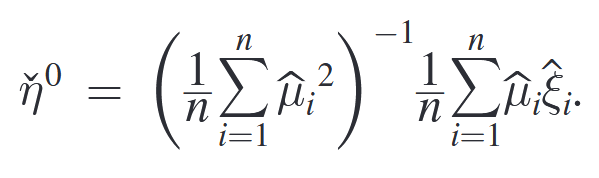

In [256]:
def computeThetaCheck(lrew_resid, ldur_resid):
    inv_term = 1/(sum(lrew_resid**2)/len(lrew_resid))
    numer_term = sum(lrew_resid * ldur_resid)/len(lrew_resid)
    theta_check = inv_term * numer_term
    return theta_check

In [308]:
def computeEta(dataset):

    ########################
    ### Part I: 估计 ###
    ########################

    print("doubleMLEstimate()")
    # 获取两次机器学习结果预测的y值，计算残差后带入到双重机器学习的估计器中

    # (LOTS OF STUFF IN THIS SECTION WILL LOOK WEIRD BECAUSE OF THE CHANGE FROM TRAIN/TEST to A/B)

    # (Set to True if you're also doing the alternative specification with
    # mean-differenced rewards and durations)
    mean_differenced = False

    # Load best reward predictions
    predicted_lrew_ab = joblib.load(os.path.join(ml_output_path,
        "predictions_" + dataset + "_fullab_rew.pkl"))
    print("Loaded predicted_lrew_ab: " + str(predicted_lrew_ab.shape))
    predicted_lrew_ba = joblib.load(os.path.join(ml_output_path,
        "predictions_" + dataset + "_fullba_rew.pkl"))
    print("Loaded predicted_lrew_ba: " + str(predicted_lrew_ba.shape))
    ## Load actual rewards
    lrew_ab = pd.read_pickle(os.path.join(ml_input_path,
        "train_rew_" + dataset + "_fullab.pkl"))
    print("Loaded lrew_ab: " + str(lrew_ab.shape))
    lrew_ba = pd.read_pickle(os.path.join(ml_input_path,
        "train_rew_" + dataset + "_fullba.pkl"))
    print("Loaded lrew_ba: " + str(lrew_ba.shape))
    ## Load actual mean-differenced rewards
    #mdlrew_train = pd.read_pickle("./train_mdrewards.pkl")
    #mdlrew_test = pd.read_pickle("./test_mdrewards.pkl")

    ## Load best duration predictions
    predicted_ldur_ab = joblib.load(os.path.join(ml_output_path,
        "predictions_" + dataset + "_fullab_dur.pkl"))
    predicted_ldur_ba = joblib.load(os.path.join(ml_output_path,
        "predictions_" + dataset + "_fullba_dur.pkl"))
    ## Load actual durations
    ldur_ab = pd.read_pickle(os.path.join(ml_input_path,
        "train_dur_" + dataset + "_fullab.pkl"))
    ldur_ba = pd.read_pickle(os.path.join(ml_input_path,
        "train_dur_" + dataset + "_fullba.pkl"))

    ## Compute reward residuals = V_hat
    # 这部分看起来奇怪是因为最近预测的集合是集合A（原始训练集），集合A的残差是lrew_train - predicted_lrew。这点对集合B也一样
    lrew_resid_ab = lrew_ba - predicted_lrew_ab
    lrew_resid_ab.rename("lrew_resid",inplace=True)
    lrew_resid_ba = lrew_ab - predicted_lrew_ba
    lrew_resid_ba.rename("lrew_resid_ba",inplace=True)
    ## Compute mean-differenced log(reward) residuals
    #mdlrew_resid = mdlrew_test - predicted_mdlrew
    #mdlrew_resid.rename("mdlrew_resid",inplace=True)
    #mdlrew_resid_flip = mdlrew_train - predicted_mdlrew_flip
    #mdlrew_resid_flip.rename("mdlrew_resid_flip",inplace=True)

    ## Compute log(duration) residuals = W_hat
    ldur_resid_ab = ldur_ba - predicted_ldur_ab
    ldur_resid_ab.rename("ldur_resid",inplace=True)
    ldur_resid_ba = ldur_ab - predicted_ldur_ba
    ldur_resid_ba.rename("ldur_resid_ba",inplace=True)
    ## Compute mean-differenced log(duration) residuals
    #mdldur_resid = mdldur_test - predicted_mdldur
    #mdldur_resid.rename("mdldur_resid",inplace=True)
    #mdldur_resid_flip = mdldur_train - predicted_mdldur_flip
    #mdldur_resid_flip.rename("mdldur_resid_flip",inplace=True)
    ## Compute log(normalized duration) residuals
    #lndur_resid = lndur - predicted_lndur
    #lndur_resid.rename("lndur_resid",inplace=True)

    ## Theta_check(log(reward) -> log(duration))
    theta_check_ab = computeThetaCheck(lrew_resid_ab, ldur_resid_ab)
    print("Standard theta_check: " + str(theta_check_ab))
    theta_check_ba = computeThetaCheck(lrew_resid_ba, ldur_resid_ba)
    print("Standard theta_check (flipped data): " + str(theta_check_ba))
    avg_theta_check = (theta_check_ab + theta_check_ba)/2
    print("Averaged theta_check: " + str(avg_theta_check))

    ## Theta_check(md(log(reward)) -> md(log(duration)))
    #theta_check_md = computeThetaCheck(mdlrew_resid, mdldur_resid)
    #print("Mean-differenced theta_check: " + str(theta_check_md))
    #theta_check_md_flip = computeThetaCheck(mdlrew_resid_flip, mdldur_resid_flip)
    #print("Mean-differenced theta_check (flipped data): " + str(theta_check_md_flip))
    #avg_theta_check_md = (theta_check_md + theta_check_md_flip) / 2
    #print("Averaged mean-differenced theta_check: " + str(avg_theta_check_md))

    # Theta_check(log(reward) -> log(normduration))
    #theta_check_ndur = computeThetaCheck(lrew_resid, lndur_resid)
    #print("Standard theta_check with normalized durations: " + str(theta_check_ndur))

    # Theta_check(md(log(reward)) -> log(normduration))
    #theta_check_md_ndur = computeThetaCheck(mdlrew_resid, lndur_resid)
    #print("Mean-differenced theta_check with normalized durations: " + str(theta_check_md_ndur))

    ###############################
    ### Part II: 导出文件 ###
    ###############################

    # 将计算出来的双重机器学习估计值，即预测值和残差值合并回原有数据集
    residual_vars = [lrew_resid_ab, ldur_resid_ab]
    residual_vars_flip = [lrew_resid_ba,ldur_resid_ba]
    if mean_differenced:
        residual_vars = residual_vars + [mdlrew_resid, mdldur_resid]
        #residual_vars_flip = residual_vars_flip + [mdlrew_resid_flip, mdldur_resid_flip]
    residual_df = pd.concat(residual_vars, axis=1)
    residual_df_flip = pd.concat(residual_vars_flip, axis=1)
    #residual_df = pd.concat([mdlrew_resid, mdldur_resid], axis=1)

    # Merge predicted vals back into the test data DFs
    residual_df["predicted_lrew"] = predicted_lrew_ab
    residual_df_flip["predicted_lrew_ba"] = predicted_lrew_ba
    if mean_differenced:
        residual_df["predicted_mdlrew"] = predicted_mdlrew
        #residual_df_flip["predicted_mdlrew_flip"] = predicted_mdlrew_flip
    residual_df["predicted_ldur"] = predicted_ldur_ab
    residual_df_flip["predicted_ldur_ba"] = predicted_ldur_ba
    if mean_differenced:
        residual_df["predicted_mdldur"] = predicted_mdldur
        residual_df_flip["predicted_mdldur_flip"] = predicted_mdldur_flip
    #residual_df["predicted_lndur"] = predicted_lndur

    if dataset == "ipeirotis":
        ## Now merge *this* residual_df back into the full dataset
        full_df = pd.read_pickle(os.path.join(cleaned_path,"ipeirotis_cleaned.pkl"))
    if dataset == "textlab_30":
        ## Or the full 400k obs TextLab 30-minute dataset
        full_df = pd.read_pickle(os.path.join(cleaned_path,"textlab_30_cleaned.pkl"))
    if dataset == "textlab_10":
        ## Or 100k obs TextLab 10-minute dataset
        full_df = pd.read_pickle(os.path.join(cleaned_path,"textlab_10_cleaned.pkl"))
    # 只有删除desc和kw才能让pandas写入dta
    if dataset != "textlab_30":
        full_df.drop("description",axis=1,inplace=True)
        full_df.drop("keywords",axis=1,inplace=True)
        full_df.drop("kw_parsed",axis=1,inplace=True)
    #full_df.drop("qualifications",axis=1,inplace=True)
    # And reset the index, so it's 0, 1, 2, ... instead of the group ids
    #full_df.index = full_df.index.astype(int)
    full_df.reset_index(inplace=True)

    # Merge the "normal" training-test split residuals in
    full_df_merged = full_df.merge(residual_df,how='left',left_index=True,right_index=True,indicator=True)
    full_df_merged["_merge"] = full_df_merged["_merge"].replace('both',1)
    full_df_merged["_merge"] = full_df_merged["_merge"].replace('left_only',0)
    full_df_merged["_merge"] = full_df_merged["_merge"].replace('right_only',0)
    full_df_merged.rename(index=str,columns={'_merge':'A_B'},inplace=True)
    # print(full_df_merged)
    full_df_merged["A_B"] = full_df_merged["A_B"].astype(int)
    full_df_merged.index = full_df_merged.index.astype(int)

    flip_vars = ["lrew_resid_ba","ldur_resid_ba","predicted_lrew_ba",
                 "predicted_ldur_ba"]
    if mean_differenced:
        flip_vars = flip_vars + ["mdlrew_resid_flip","mdldur_resid_flip",
                                "predicted_mdlrew_flip","predicted_mdldur_flip"]

    # And merge the flipped residuals in
    full_df_merged = full_df_merged.merge(residual_df_flip,how='left',left_index=True,right_index=True,indicator=True)
    full_df_merged["_merge"] = full_df_merged["_merge"].replace('both',2)
    full_df_merged["_merge"] = full_df_merged["_merge"].replace('left_only',0)
    full_df_merged["_merge"] = full_df_merged["_merge"].replace('right_only',0)
    full_df_merged["_merge"] = full_df_merged["_merge"].astype(int)
    full_df_merged["A_B"] = full_df_merged["A_B"] + full_df_merged["_merge"]
    full_df_merged.drop("_merge",axis=1,inplace=True)

    # Now fill the (non-flipped) NaN values with the flipped values
    full_df_merged["lrew_resid"] = full_df_merged["lrew_resid"].fillna(full_df_merged["lrew_resid_ba"])
    #full_df_merged["mdlrew_resid"] = full_df_merged["mdlrew_resid"].fillna(full_df_merged["mdlrew_resid_flip"])
    full_df_merged["ldur_resid"] = full_df_merged["ldur_resid"].fillna(full_df_merged["ldur_resid_ba"])
    #full_df_merged["mdldur_resid"] = full_df_merged["mdldur_resid"].fillna(full_df_merged["mdldur_resid_flip"])
    full_df_merged["predicted_lrew"] = full_df_merged["predicted_lrew"].fillna(full_df_merged["predicted_lrew_ba"])
    #full_df_merged["predicted_mdlrew"] = full_df_merged["predicted_mdlrew"].fillna(full_df_merged["predicted_mdlrew_flip"])
    full_df_merged["predicted_ldur"] = full_df_merged["predicted_ldur"].fillna(full_df_merged["predicted_ldur_ba"])
    #full_df_merged["predicted_mdldur"] = full_df_merged["predicted_mdldur"].fillna(full_df_merged["predicted_mdldur_flip"])

    full_df_merged.drop(flip_vars,axis=1,inplace=True)

    #####################
    ### The export!!! ###
    #####################

    # Load the R^2 terms from the ML runs
    format_str = "{0:.4f}"
    lrew_r2 = format_str.format(joblib.load(os.path.join(ml_output_path,
        "pred_score_" + dataset + "_fullab_rew.pkl")))
    lrew_r2_flip = format_str.format(joblib.load(os.path.join(ml_output_path,
        "pred_score_" + dataset + "_fullba_rew.pkl")))
    ldur_r2 = format_str.format(joblib.load(os.path.join(ml_output_path,
        "pred_score_" + dataset + "_fullab_dur.pkl")))
    ldur_r2_flip = format_str.format(joblib.load(os.path.join(ml_output_path,
        "pred_score_" + dataset + "_fullba_dur.pkl")))
    if mean_differenced:
        mdlrew_r2 = format_str.format(joblib.load(os.path.join(ml_output_path,
            "pred_score_rfr_mdlrew.pkl")))
        #mdlrew_r2_flip = format_str.format(joblib.load("pred_score_rfr_mdlrewflip.pkl"))
        mdldur_r2 = format_str.format(joblib.load(os.path.join(ml_output_path,
            "pred_score_rfr_mdldur.pkl")))
        #mdldur_r2_flip = format_str.format(joblib.load("pred_score_rfr_mdldurflip.pkl"))

    # Export dataset of residuals to Stata
    label_map = {}
    label_map["lrew_resid"] = "log(reward) residuals. Rsq_0 = " + lrew_r2 + ", Rsq_1 = " + lrew_r2_flip
    label_map["ldur_resid"] = "log(duration) residuals. Rsq_0 = " + ldur_r2 + ", Rsq_1 = " + ldur_r2_flip
    if mean_differenced:
        label_map["mdlrew_resid"] = "Mean-differenced log(reward) residuals. Rsq_0 = " + mdlrew_r2 + ", Rsq_1 = " + mdlrew_r2_flip
        label_map["mdldur_resid"] = "Mean-differenced log(duration) residuals. Rsq_0 = " + mdldur_r2 + ", Rsq_1 = " + mdldur_r2_flip
    label_map["A_B"] = "0 if not used, 1 if in Set A (first train data), 2 if in Set B (first test data)"
    residuals_filepath = os.path.join(estimates_path, "residuals_full_" + dataset + ".dta")
    if "level_0" in full_df_merged.columns:
        full_df_merged.drop("level_0",axis=1,inplace=True)
    if "qualifications" in full_df_merged.columns:
        full_df_merged.drop("qualifications",axis=1,inplace=True)
    full_df_merged.to_stata(residuals_filepath, variable_labels=label_map)
    print("Exported Stata file " + residuals_filepath)

### （九）正式计算

In [281]:
# 根据之前的分组计算特征，将其分为训练集和测试集
# A->B run with just n-gram features
for dataset in all_datasets:
    print("*** A->B n-gram ML run")
    prepareML(dataset, "gramab")
    runML(dataset, "gramab")
    # Compute and save the most predictive features
    print("*** A->B computing most predictive features")
    computeMostPredictive(dataset, "gramab")
    # Now the second ML run, using the most predictive features plus the rest
    # of the features detailed in Appendix D
    print("*** A->B full ML run")
    prepareML(dataset, "fullab")
    runML(dataset, "fullab")

*** A->B n-gram ML run
# A obs: 129751
# B obs: 129751
# A_train obs: 103800
# A_val obs: 25951
# B_train obs: 103800
# B_val obs: 25951


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["description"] = feature_df["description"].astype(str)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["kw_parsed"] = feature_df["kw_parsed"].astype(str)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

Descriptions vectorized for train data
Keywords vectorized for train data
Titles vectorized for train data
(103800, 419295)
(103800, 8952)
(103800, 282599)
Feature names saved to .\ml_input\feat_names_ipeirotis_gramab.pkl
Validation set descriptions vectorized
Validation set keywords vectorized
Validation set titles vectorized
(25951, 419295)
(25951, 8952)
(25951, 282599)
Train rewards saved to .\ml_input\./train_rew_ipeirotis_gramab.pkl
Train durations saved to .\ml_input\./train_dur_ipeirotis_gramab.pkl
Train text features saved to .\ml_input\./train_txtfeats_ipeirotis_gramab.pkl
Training data saved
Test rewards saved to .\ml_input\./test_rew_ipeirotis_gramab.pkl
Test durations saved to .\ml_input\./test_dur_ipeirotis_gramab.pkl
Test text features saved to .\ml_input\./test_txtfeats_ipeirotis_gramab.pkl
Validation data saved
Textual features exported
*** Train data: ***
Features: (103800, 710846)
Reward labels: (103800,)
Duration labels: (103800,)
*** Validation data: ***
Features: (

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 25 of 40


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 15.2min


building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed: 15.5min remaining: 28.7min


building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 24.6min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 24.6min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.


ipeirotis_gramab_rew fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


fitAndPredict: 1478.6810615062714 seconds
0.7661512227220669
----- [Running *duration* ML with text features] -----
Running ipeirotis_gramab_dur
building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 30.1min


building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed: 31.1min remaining: 57.8min


building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 49.5min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 49.9min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.


ipeirotis_gramab_dur fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.1s finished


fitAndPredict: 2991.8724117279053 seconds
0.4042878636049796
*** A->B computing most predictive features
Generating most predictive features for dur
Number of features: 710846
Features outputted to: .\predictive_feats\predictive_ipeirotis_gramab_dur.csv
Generating most predictive features for rew
Number of features: 710846
Features outputted to: .\predictive_feats\predictive_ipeirotis_gramab_rew.csv
*** A->B full ML run
# A obs: 129751
# B obs: 129751
# A_train obs: 103800
# A_val obs: 25951
# B_train obs: 103800
# B_val obs: 25951
Number of description features: 93
Number of title features: 75
Number of keyword features: 32
Computing feature #0: easy
Computing feature #1: transcribe
Computing feature #2: writing
Computing feature #3: audio
Computing feature #4: image
Computing feature #5: video
Computing feature #6: bonus
Computing feature #7: copy
Computing feature #8: search
Computing feature #9: identify
Computing feature #10: text
Computing feature #11: date
Computing feature #12:

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[desc_var] = (hit_df["desc_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:20: PerformanceWarning: DataFrame is highly fragmented.  This 

Computing feature #28: click
Computing feature #29: link


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[desc_var] = (hit_df["desc_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[kw_var] = (hit_df["kw_lower"].str.count(str_to_search).fillna(0)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:15: PerformanceWarning: DataFrame is highly fragmented.  T

Computing feature #30: read


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  Thi

LDA features merged in
Doc2Vec features merged in
                              group_id      duration  log_duration  reward  \
259497  3ZY19HV01BIMKUJC8R23XWPE2U4GSE   1512.933333      7.321806       5   
259498  3ZY19HV01BIUAL70JGMVTT0E150GSD     35.766667      3.577016      40   
259499  3ZY19HV01BMN1HMYRKAG7N9SYLVGSY    396.566667      5.982844      15   
259500            4YFZK2ZCCXSZ64ZJNTR0     34.916667      3.552964       5   
259501            J1ZZNQGNTW1YZVD8FWTZ  20171.916667      9.912047       5   

        log_reward  meandiff_lreward  meandiff_ldur  time_allotted  \
259497    1.609438         -0.405465      -0.990035           1500   
259498    3.688879          0.000000      -4.468027           3600   
259499    2.708050         -0.815037      -2.454863           3600   
259500    1.609438          0.000000       0.000000           1200   
259501    1.609438          0.000000       1.182741           3600   

        first_hits  last_hits  ...  doc2vec_kw_40  doc2vec_k

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Train features saved to .\ml_input\./train_feats_ipeirotis_fullab.pkl
Training data saved
Test rewards saved to .\ml_input\./test_rew_ipeirotis_fullab.pkl
Test durations saved to .\ml_input\./test_dur_ipeirotis_fullab.pkl


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

Test features saved to .\ml_input\./test_feats_ipeirotis_fullab.pkl
Test data saved
Training data dimensions: (129751, 322)
Test data dimensions: (129751, 322)
Training data loaded
Test data loaded
----- [Running *reward* ML with numeric features] -----
Running ipeirotis_fullab_rew


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 600building tree 2 of 600

building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   16.8s


building tree 140 of 600
building tree 141 of 600
building tree 142 of 600
building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   45.6s


building tree 342 of 600
building tree 343 of 600
building tree 344 of 600
building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.4min finished


ipeirotis_fullab_rew fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    1.0s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    1.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    1.0s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


fitAndPredict: 121.61769008636475 seconds
0.7745966437571489
----- [Running *duration* ML with numeric features] -----
Running ipeirotis_fullab_dur
building tree 1 of 600
building tree 2 of 600
building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 6

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   18.0s


building tree 139 of 600
building tree 140 of 600
building tree 141 of 600
building tree 142 of 600
building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   48.0s


building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600
building tree 383 of 600
building tree 384 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.5min finished


ipeirotis_fullab_dur fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    1.0s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    1.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    1.0s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    1.9s finished


fitAndPredict: 129.6943142414093 seconds
0.8972814317031571
*** A->B n-gram ML run
# A obs: 146373
# B obs: 146373
# A_train obs: 117098
# A_val obs: 29275
# B_train obs: 117098
# B_val obs: 29275


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["title"] = feature_df["title"].astype(str)


Titles vectorized for train data
(117098, 418949)
Feature names saved to .\ml_input\feat_names_textlab_30_gramab.pkl
Validation set titles vectorized
(29275, 418949)
Train rewards saved to .\ml_input\./train_rew_textlab_30_gramab.pkl
Train durations saved to .\ml_input\./train_dur_textlab_30_gramab.pkl
Train text features saved to .\ml_input\./train_txtfeats_textlab_30_gramab.pkl
Training data saved
Test rewards saved to .\ml_input\./test_rew_textlab_30_gramab.pkl
Test durations saved to .\ml_input\./test_dur_textlab_30_gramab.pkl
Test text features saved to .\ml_input\./test_txtfeats_textlab_30_gramab.pkl
Validation data saved
Textual features exported
*** Train data: ***
Features: (117098, 418949)
Reward labels: (117098,)
Duration labels: (117098,)
*** Validation data: ***
Features: (29275, 418949)
Reward labels: (29275,)
Duration labels: (29275,)
Training data loaded
Test data loaded
----- [Running *reward* ML with text features] -----
Running textlab_30_gramab_rew


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 40building tree 2 of 40
building tree 3 of 40

building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.5min


building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:  6.7min remaining: 12.5min


building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 10.7min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 10.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s


textlab_30_gramab_rew fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


fitAndPredict: 647.8112711906433 seconds
0.8658655199892127
----- [Running *duration* ML with text features] -----
Running textlab_30_gramab_dur
building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 13.0min


building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed: 13.4min remaining: 24.8min


building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 21.7min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 21.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.


textlab_30_gramab_dur fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.1s finished


fitAndPredict: 1310.1504600048065 seconds
0.2694385474524966
*** A->B computing most predictive features
Generating most predictive features for dur
Number of features: 418949
Features outputted to: .\predictive_feats\predictive_textlab_30_gramab_dur.csv
Generating most predictive features for rew
Number of features: 418949
Features outputted to: .\predictive_feats\predictive_textlab_30_gramab_rew.csv
*** A->B full ML run
# A obs: 146373
# B obs: 146373
# A_train obs: 117098
# A_val obs: 29275
# B_train obs: 117098
# B_val obs: 29275
Number of description features: 0
Number of title features: 200
Number of keyword features: 0
Computing feature #0: easy
Computing feature #1: transcribe
Computing feature #2: writing
Computing feature #3: audio
Computing feature #4: image
Computing feature #5: video
Computing feature #6: bonus
Computing feature #7: copy
Computing feature #8: search
Computing feature #9: identify
Computing feature #10: text
Computing feature #11: date
Computing feature #12

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  Thi

LDA features merged in
Doc2Vec features merged in
                                group_id  duration  log_duration  reward  \
292741  fffdae03eb029f2d8e60eabaa971adc2     240.0      5.480639     2.0   
292742  ffff1d8b216a25a0619474b6a465dde5     120.0      4.787492   369.0   
292743  ffff9f464f1e1d0a8c9e8588ce435e5e    5220.0      8.560253    15.0   
292744  ffffc1d9b78826955e9687d8c6ca714a    2910.0      7.975908    60.0   
292745  ffffc57feb6f5ee5ef5d95a54548bcc5     120.0      4.787492     2.0   

        log_reward  meandiff_lreward  meandiff_ldur  time_allotted  \
292741    0.693147         -4.308529      -1.490776             60   
292742    5.910797          0.909121      -2.183924             60   
292743    2.708050         -0.105361      -0.034272             10   
292744    4.094345          0.017075      -0.527354             60   
292745    0.693147          0.000000      -0.406011              8   

        first_hits  last_hits  ...  doc2vec_title_40  doc2vec_title_41  

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Train features saved to .\ml_input\./train_feats_textlab_30_fullab.pkl
Training data saved
Test rewards saved to .\ml_input\./test_rew_textlab_30_fullab.pkl
Test durations saved to .\ml_input\./test_dur_textlab_30_fullab.pkl


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

Test features saved to .\ml_input\./test_feats_textlab_30_fullab.pkl
Test data saved
Training data dimensions: (146373, 245)
Test data dimensions: (146373, 245)
Training data loaded
Test data loaded
----- [Running *reward* ML with numeric features] -----
Running textlab_30_fullab_rew


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 600building tree 2 of 600
building tree 3 of 600

building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   12.5s


building tree 140 of 600
building tree 141 of 600
building tree 142 of 600
building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   33.3s


building tree 343 of 600
building tree 344 of 600
building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.0min finished


textlab_30_fullab_rew fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.9s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


fitAndPredict: 89.95465922355652 seconds
0.8948259642306319
----- [Running *duration* ML with numeric features] -----
Running textlab_30_fullab_dur
building tree 1 of 600
building tree 2 of 600
building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 6

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   15.3s


building tree 141 of 600
building tree 142 of 600
building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   41.2s


building tree 343 of 600
building tree 344 of 600
building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished


textlab_30_fullab_dur fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    2.9s finished


fitAndPredict: 115.27418088912964 seconds
0.43851247094014834
*** A->B n-gram ML run
# A obs: 46887
# B obs: 46888
# A_train obs: 37509
# A_val obs: 9378
# B_train obs: 37510
# B_val obs: 9378


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["description"] = feature_df["description"].astype(str)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["kw_parsed"] = feature_df["kw_parsed"].astype(str)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

Descriptions vectorized for train data
Keywords vectorized for train data
Titles vectorized for train data
(37509, 82701)
(37509, 3553)
(37509, 134055)
Feature names saved to .\ml_input\feat_names_textlab_10_gramab.pkl
Validation set descriptions vectorized
Validation set keywords vectorized
Validation set titles vectorized
(9378, 82701)
(9378, 3553)
(9378, 134055)
Train rewards saved to .\ml_input\./train_rew_textlab_10_gramab.pkl
Train durations saved to .\ml_input\./train_dur_textlab_10_gramab.pkl
Train text features saved to .\ml_input\./train_txtfeats_textlab_10_gramab.pkl
Training data saved
Test rewards saved to .\ml_input\./test_rew_textlab_10_gramab.pkl
Test durations saved to .\ml_input\./test_dur_textlab_10_gramab.pkl
Test text features saved to .\ml_input\./test_txtfeats_textlab_10_gramab.pkl
Validation data saved
Textual features exported
*** Train data: ***
Features: (37509, 220309)
Reward labels: (37509,)
Duration labels: (37509,)
*** Validation data: ***
Features: (9378

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 25 of 40


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.1s


building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:   39.3s remaining:  1.2min


building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  1.1min remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


textlab_10_gramab_rew fit complete
Fitted model saved
fitAndPredict: 68.97812151908875 seconds
0.8763084043022822
----- [Running *duration* ML with text features] -----
Running textlab_10_gramab_dur
building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min


building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:  1.4min remaining:  2.7min


building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  2.5min remaining:   21.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.6min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished


textlab_10_gramab_dur fit complete
Fitted model saved
fitAndPredict: 153.5969340801239 seconds
0.3791504779174041
*** A->B computing most predictive features
Generating most predictive features for dur
Number of features: 220309
Features outputted to: .\predictive_feats\predictive_textlab_10_gramab_dur.csv
Generating most predictive features for rew
Number of features: 220309
Features outputted to: .\predictive_feats\predictive_textlab_10_gramab_rew.csv
*** A->B full ML run
# A obs: 46887
# B obs: 46888
# A_train obs: 37509
# A_val obs: 9378
# B_train obs: 37510
# B_val obs: 9378
Number of description features: 54
Number of title features: 103
Number of keyword features: 43
Computing feature #0: easy
Computing feature #1: transcribe
Computing feature #2: writing
Computing feature #3: audio
Computing feature #4: image
Computing feature #5: video
Computing feature #6: bonus
Computing feature #7: copy
Computing feature #8: search
Computing feature #9: identify
Computing feature #10: text


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[desc_var] = (hit_df["desc_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:20: PerformanceWarning: DataFrame is highly fragmented.  This 

Computing feature #30: read


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[desc_var] = (hit_df["desc_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[kw_var] = (hit_df["kw_lower"].str.count(str_to_search).fillna(0)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  T

LDA features merged in
Doc2Vec features merged in
                             group_id  duration  log_duration  reward  \
93770  3ZY19HV01BONLIR1KK5SXUJQHSGGS1   60950.0     11.017809    44.0   
93771  3ZY19HV01BONLIR1KK5SXUJQHSIGS3   14720.0      9.596962    52.0   
93772  3ZY19HV01BONLIR1KK5SXUJQIWEGS8   19640.0      9.885324    78.0   
93773  3ZY19HV01BPM76GKCNBV9R7GD76SG1    5930.0      8.687779    10.0   
93774  3ZY19HV01BSBSMWQ8SJ63FS1C9KSG5   32060.0     10.375364   350.0   

       log_reward  meandiff_lreward  meandiff_ldur  time_allotted  first_hits  \
93770    3.784190          0.232745       0.775686             22           0   
93771    3.951244          0.399799      -0.645160             26           0   
93772    4.356709          0.805264      -0.356799             39           0   
93773    2.302585         -0.370374       0.813040             60           0   
93774    5.857933          0.292848      -0.045906            300           0   

       last_hits  ...  d

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Train features saved to .\ml_input\./train_feats_textlab_10_fullab.pkl
Training data saved
Test rewards saved to .\ml_input\./test_rew_textlab_10_fullab.pkl
Test durations saved to .\ml_input\./test_dur_textlab_10_fullab.pkl
Test features saved to .\ml_input\./test_feats_textlab_10_fullab.pkl
Test data saved
Training data dimensions: (46887, 314)
Test data dimensions: (46888, 314)
Training data loaded


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

Test data loaded
----- [Running *reward* ML with numeric features] -----
Running textlab_10_fullab_rew
building tree 1 of 600
building tree 2 of 600
building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 43 of 600
building tree 44 of 600
building tree 45 of 600
building tree 46 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 55 of 600
building tree 56 of 600
building tree 57 of 600
building tree 58 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61 of 600
building tree 62 of 600
building tree 63 of 600
building tree 64 of 600
building tree 65 of 600
building tree 66

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    2.8s


building tree 142 of 600
building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:    7.8s


building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600
building tree 383 of 600
building tree 384 of 600
building tree 385 of 600
building tree 386 of 600
building tree 387 of 600
building tree 388 of 600
building tree 389 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   14.5s finished


textlab_10_fullab_rew fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


fitAndPredict: 25.128639698028564 seconds
0.8986011617442209
----- [Running *duration* ML with numeric features] -----
Running textlab_10_fullab_dur
building tree 1 of 600
building tree 2 of 600
building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    2.7s


building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:    7.8s


building tree 344 of 600building tree 345 of 600

building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600
building tree 383 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   14.9s finished


textlab_10_fullab_dur fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.1s


fitAndPredict: 26.265891551971436 seconds
0.5086904671748376


[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.3s finished


In [282]:
for dataset in all_datasets:
# Repeat the above, but for the B->A run
    print("*** B->A n-gram ML run")
    prepareML(dataset, "gramba")
    runML(dataset, "gramba")
    print("*** B->A computing most predictive features")
    computeMostPredictive(dataset, "gramba")
    print("*** B->A full ML run")
    prepareML(dataset, "fullba")
    runML(dataset, "fullba")

*** B->A n-gram ML run
# A obs: 129751
# B obs: 129751
# A_train obs: 103800
# A_val obs: 25951
# B_train obs: 103800
# B_val obs: 25951


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["description"] = feature_df["description"].astype(str)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["kw_parsed"] = feature_df["kw_parsed"].astype(str)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

Descriptions vectorized for train data
Keywords vectorized for train data
Titles vectorized for train data
(103800, 421264)
(103800, 9077)
(103800, 283234)
Feature names saved to .\ml_input\feat_names_ipeirotis_gramba.pkl
Validation set descriptions vectorized
Validation set keywords vectorized
Validation set titles vectorized
(25951, 421264)
(25951, 9077)
(25951, 283234)
Train rewards saved to .\ml_input\./train_rew_ipeirotis_gramba.pkl
Train durations saved to .\ml_input\./train_dur_ipeirotis_gramba.pkl
Train text features saved to .\ml_input\./train_txtfeats_ipeirotis_gramba.pkl
Training data saved
Test rewards saved to .\ml_input\./test_rew_ipeirotis_gramba.pkl
Test durations saved to .\ml_input\./test_dur_ipeirotis_gramba.pkl
Test text features saved to .\ml_input\./test_txtfeats_ipeirotis_gramba.pkl
Validation data saved
Textual features exported
*** Train data: ***
Features: (103800, 713575)
Reward labels: (103800,)
Duration labels: (103800,)
*** Validation data: ***
Features: (

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 25 of 40


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 15.1min


building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed: 15.4min remaining: 28.7min


building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 24.5min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 24.5min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.


ipeirotis_gramba_rew fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


fitAndPredict: 1472.277501821518 seconds
0.7655546683835237
----- [Running *duration* ML with text features] -----
Running ipeirotis_gramba_dur
building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 28.9min


building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed: 29.7min remaining: 55.2min


building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 47.7min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 47.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.


ipeirotis_gramba_dur fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.1s finished


fitAndPredict: 2870.4311413764954 seconds
0.4071585242707978
*** B->A computing most predictive features
Generating most predictive features for dur
Number of features: 713575
Features outputted to: .\predictive_feats\predictive_ipeirotis_gramba_dur.csv
Generating most predictive features for rew
Number of features: 713575
Features outputted to: .\predictive_feats\predictive_ipeirotis_gramba_rew.csv
*** B->A full ML run
# A obs: 129751
# B obs: 129751
# A_train obs: 103800
# A_val obs: 25951
# B_train obs: 103800
# B_val obs: 25951
Number of description features: 94
Number of title features: 73
Number of keyword features: 33
Computing feature #0: easy
Computing feature #1: transcribe
Computing feature #2: writing
Computing feature #3: audio
Computing feature #4: image
Computing feature #5: video
Computing feature #6: bonus
Computing feature #7: copy
Computing feature #8: search
Computing feature #9: identify
Computing feature #10: text
Computing feature #11: date
Computing feature #12:

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[desc_var] = (hit_df["desc_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:20: PerformanceWarning: DataFrame is highly fragmented.  This 

Computing feature #28: click
Computing feature #29: link


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[desc_var] = (hit_df["desc_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[kw_var] = (hit_df["kw_lower"].str.count(str_to_search).fillna(0)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:15: PerformanceWarning: DataFrame is highly fragmented.  T

Computing feature #30: read


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  Thi

LDA features merged in
Doc2Vec features merged in
                              group_id      duration  log_duration  reward  \
259497  3ZY19HV01BIMKUJC8R23XWPE2U4GSE   1512.933333      7.321806       5   
259498  3ZY19HV01BIUAL70JGMVTT0E150GSD     35.766667      3.577016      40   
259499  3ZY19HV01BMN1HMYRKAG7N9SYLVGSY    396.566667      5.982844      15   
259500            4YFZK2ZCCXSZ64ZJNTR0     34.916667      3.552964       5   
259501            J1ZZNQGNTW1YZVD8FWTZ  20171.916667      9.912047       5   

        log_reward  meandiff_lreward  meandiff_ldur  time_allotted  \
259497    1.609438         -0.405465      -0.990035           1500   
259498    3.688879          0.000000      -4.468027           3600   
259499    2.708050         -0.815037      -2.454863           3600   
259500    1.609438          0.000000       0.000000           1200   
259501    1.609438          0.000000       1.182741           3600   

        first_hits  last_hits  ...  doc2vec_kw_40  doc2vec_k

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Train features saved to .\ml_input\./train_feats_ipeirotis_fullba.pkl
Training data saved
Test rewards saved to .\ml_input\./test_rew_ipeirotis_fullba.pkl
Test durations saved to .\ml_input\./test_dur_ipeirotis_fullba.pkl


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

Test features saved to .\ml_input\./test_feats_ipeirotis_fullba.pkl
Test data saved
Training data dimensions: (129751, 322)
Test data dimensions: (129751, 322)
Training data loaded
Test data loaded
----- [Running *reward* ML with numeric features] -----
Running ipeirotis_fullba_rew


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 600building tree 2 of 600

building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   17.4s


building tree 141 of 600
building tree 142 of 600
building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600building tree 150 of 600

building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   45.3s


building tree 343 of 600
building tree 344 of 600
building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.4min finished


ipeirotis_fullba_rew fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.9s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    1.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    1.0s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


fitAndPredict: 121.50878810882568 seconds
0.7746620772327191
----- [Running *duration* ML with numeric features] -----
Running ipeirotis_fullba_dur
building tree 1 of 600
building tree 2 of 600
building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 6

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   17.4s


building tree 140 of 600
building tree 141 of 600
building tree 142 of 600
building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   45.9s


building tree 342 of 600
building tree 343 of 600
building tree 344 of 600
building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.4min finished


ipeirotis_fullba_dur fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    1.0s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    1.0s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    1.9s finished


fitAndPredict: 125.45697808265686 seconds
0.8971990578092152
*** B->A n-gram ML run
# A obs: 146373
# B obs: 146373
# A_train obs: 117098
# A_val obs: 29275
# B_train obs: 117098
# B_val obs: 29275


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["title"] = feature_df["title"].astype(str)


Titles vectorized for train data
(117098, 418112)
Feature names saved to .\ml_input\feat_names_textlab_30_gramba.pkl
Validation set titles vectorized
(29275, 418112)
Train rewards saved to .\ml_input\./train_rew_textlab_30_gramba.pkl
Train durations saved to .\ml_input\./train_dur_textlab_30_gramba.pkl
Train text features saved to .\ml_input\./train_txtfeats_textlab_30_gramba.pkl
Training data saved
Test rewards saved to .\ml_input\./test_rew_textlab_30_gramba.pkl
Test durations saved to .\ml_input\./test_dur_textlab_30_gramba.pkl
Test text features saved to .\ml_input\./test_txtfeats_textlab_30_gramba.pkl
Validation data saved
Textual features exported
*** Train data: ***
Features: (117098, 418112)
Reward labels: (117098,)
Duration labels: (117098,)
*** Validation data: ***
Features: (29275, 418112)
Reward labels: (29275,)
Duration labels: (29275,)
Training data loaded
Test data loaded
----- [Running *reward* ML with text features] -----
Running textlab_30_gramba_rew


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 40building tree 2 of 40

building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.5min


building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:  6.8min remaining: 12.6min


building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 10.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 10.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.


textlab_30_gramba_rew fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


fitAndPredict: 650.3174576759338 seconds
0.8559067924358515
----- [Running *duration* ML with text features] -----
Running textlab_30_gramba_dur
building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 12.8min


building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed: 13.4min remaining: 24.8min


building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 21.6min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 21.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.


textlab_30_gramba_dur fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.1s finished


fitAndPredict: 1309.2180652618408 seconds
0.2625678748028928
*** B->A computing most predictive features
Generating most predictive features for dur
Number of features: 418112
Features outputted to: .\predictive_feats\predictive_textlab_30_gramba_dur.csv
Generating most predictive features for rew
Number of features: 418112
Features outputted to: .\predictive_feats\predictive_textlab_30_gramba_rew.csv
*** B->A full ML run
# A obs: 146373
# B obs: 146373
# A_train obs: 117098
# A_val obs: 29275
# B_train obs: 117098
# B_val obs: 29275
Number of description features: 0
Number of title features: 200
Number of keyword features: 0
Computing feature #0: easy
Computing feature #1: transcribe
Computing feature #2: writing
Computing feature #3: audio
Computing feature #4: image
Computing feature #5: video
Computing feature #6: bonus
Computing feature #7: copy
Computing feature #8: search
Computing feature #9: identify
Computing feature #10: text
Computing feature #11: date
Computing feature #12

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  Thi

LDA features merged in
Doc2Vec features merged in
                                group_id  duration  log_duration  reward  \
292741  fffdae03eb029f2d8e60eabaa971adc2     240.0      5.480639     2.0   
292742  ffff1d8b216a25a0619474b6a465dde5     120.0      4.787492   369.0   
292743  ffff9f464f1e1d0a8c9e8588ce435e5e    5220.0      8.560253    15.0   
292744  ffffc1d9b78826955e9687d8c6ca714a    2910.0      7.975908    60.0   
292745  ffffc57feb6f5ee5ef5d95a54548bcc5     120.0      4.787492     2.0   

        log_reward  meandiff_lreward  meandiff_ldur  time_allotted  \
292741    0.693147         -4.308529      -1.490776             60   
292742    5.910797          0.909121      -2.183924             60   
292743    2.708050         -0.105361      -0.034272             10   
292744    4.094345          0.017075      -0.527354             60   
292745    0.693147          0.000000      -0.406011              8   

        first_hits  last_hits  ...  doc2vec_title_40  doc2vec_title_41  

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Train features saved to .\ml_input\./train_feats_textlab_30_fullba.pkl
Training data saved
Test rewards saved to .\ml_input\./test_rew_textlab_30_fullba.pkl
Test durations saved to .\ml_input\./test_dur_textlab_30_fullba.pkl


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

Test features saved to .\ml_input\./test_feats_textlab_30_fullba.pkl
Test data saved
Training data dimensions: (146373, 245)
Test data dimensions: (146373, 245)
Training data loaded
Test data loaded
----- [Running *reward* ML with numeric features] -----
Running textlab_30_fullba_rew


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 600
building tree 2 of 600
building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   11.6s


building tree 141 of 600
building tree 142 of 600
building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   31.9s


building tree 342 of 600building tree 343 of 600

building tree 344 of 600
building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   59.0s finished


textlab_30_fullba_rew fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    1.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


fitAndPredict: 87.16325283050537 seconds
0.8944850863659228
----- [Running *duration* ML with numeric features] -----
Running textlab_30_fullba_dur
building tree 1 of 600
building tree 2 of 600
building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 6

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   15.6s


building tree 139 of 600
building tree 140 of 600
building tree 141 of 600
building tree 142 of 600
building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   42.7s


building tree 344 of 600
building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600
building tree 383 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished


textlab_30_fullba_dur fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    3.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    3.0s finished


fitAndPredict: 117.23593020439148 seconds
0.44233408783918216
*** B->A n-gram ML run
# A obs: 46887
# B obs: 46888
# A_train obs: 37509
# A_val obs: 9378
# B_train obs: 37510
# B_val obs: 9378


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["description"] = feature_df["description"].astype(str)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["kw_parsed"] = feature_df["kw_parsed"].astype(str)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\1619589998.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

Descriptions vectorized for train data
Keywords vectorized for train data
Titles vectorized for train data
(37510, 84971)
(37510, 3531)
(37510, 134509)
Feature names saved to .\ml_input\feat_names_textlab_10_gramba.pkl
Validation set descriptions vectorized
Validation set keywords vectorized
Validation set titles vectorized
(9378, 84971)
(9378, 3531)
(9378, 134509)
Train rewards saved to .\ml_input\./train_rew_textlab_10_gramba.pkl
Train durations saved to .\ml_input\./train_dur_textlab_10_gramba.pkl
Train text features saved to .\ml_input\./train_txtfeats_textlab_10_gramba.pkl
Training data saved
Test rewards saved to .\ml_input\./test_rew_textlab_10_gramba.pkl
Test durations saved to .\ml_input\./test_dur_textlab_10_gramba.pkl
Test text features saved to .\ml_input\./test_txtfeats_textlab_10_gramba.pkl
Validation data saved
Textual features exported
*** Train data: ***
Features: (37510, 223011)
Reward labels: (37510,)
Duration labels: (37510,)
*** Validation data: ***
Features: (9378

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 25 of 40


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.0s


building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:   40.6s remaining:  1.3min


building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  1.2min remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


textlab_10_gramba_rew fit complete
Fitted model saved
fitAndPredict: 71.32107877731323 seconds
0.8783569450346098
----- [Running *duration* ML with text features] -----
Running textlab_10_gramba_dur
building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min


building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40


[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:  1.4min remaining:  2.6min


building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  2.5min remaining:   21.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.5min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished


textlab_10_gramba_dur fit complete
Fitted model saved
fitAndPredict: 151.81178164482117 seconds
0.37133279297204114
*** B->A computing most predictive features
Generating most predictive features for dur
Number of features: 223011
Features outputted to: .\predictive_feats\predictive_textlab_10_gramba_dur.csv
Generating most predictive features for rew
Number of features: 223011
Features outputted to: .\predictive_feats\predictive_textlab_10_gramba_rew.csv
*** B->A full ML run
# A obs: 46887
# B obs: 46888
# A_train obs: 37509
# A_val obs: 9378
# B_train obs: 37510
# B_val obs: 9378
Number of description features: 54
Number of title features: 101
Number of keyword features: 45
Computing feature #0: easy
Computing feature #1: transcribe
Computing feature #2: writing
Computing feature #3: audio
Computing feature #4: image
Computing feature #5: video
Computing feature #6: bonus
Computing feature #7: copy
Computing feature #8: search
Computing feature #9: identify
Computing feature #10: tex

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[desc_var] = (hit_df["desc_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:20: PerformanceWarning: DataFrame is highly fragmented.  This 

Computing feature #30: read


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[kw_var] = (hit_df["kw_lower"].str.count(str_to_search).fillna(0)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[title_var] = (hit_df["title_lower"].str.count(str_to_search)).astype(int)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\3308281101.py:54: PerformanceWarning: DataFrame is highly fragmented. 

LDA features merged in
Doc2Vec features merged in
                             group_id  duration  log_duration  reward  \
93770  3ZY19HV01BONLIR1KK5SXUJQHSGGS1   60950.0     11.017809    44.0   
93771  3ZY19HV01BONLIR1KK5SXUJQHSIGS3   14720.0      9.596962    52.0   
93772  3ZY19HV01BONLIR1KK5SXUJQIWEGS8   19640.0      9.885324    78.0   
93773  3ZY19HV01BPM76GKCNBV9R7GD76SG1    5930.0      8.687779    10.0   
93774  3ZY19HV01BSBSMWQ8SJ63FS1C9KSG5   32060.0     10.375364   350.0   

       log_reward  meandiff_lreward  meandiff_ldur  time_allotted  first_hits  \
93770    3.784190          0.232745       0.775686             22           0   
93771    3.951244          0.399799      -0.645160             26           0   
93772    4.356709          0.805264      -0.356799             39           0   
93773    2.302585         -0.370374       0.813040             60           0   
93774    5.857933          0.292848      -0.045906            300           0   

       last_hits  ...  d

C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Train features saved to .\ml_input\./train_feats_textlab_10_fullba.pkl
Training data saved
Test rewards saved to .\ml_input\./test_rew_textlab_10_fullba.pkl
Test durations saved to .\ml_input\./test_dur_textlab_10_fullba.pkl
Test features saved to .\ml_input\./test_feats_textlab_10_fullba.pkl
Test data saved
Training data dimensions: (46888, 314)
Test data dimensions: (46887, 314)
Training data loaded


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop([col_name],axis=1,inplace=True)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2253851036.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

Test data loaded
----- [Running *reward* ML with numeric features] -----
Running textlab_10_fullba_rew
building tree 1 of 600
building tree 2 of 600
building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 25 of 600building tree 26 of 600

building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 43 of 600
building tree 44 of 600
building tree 45 of 600
building tree 46 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 55 of 600
building tree 56 of 600
building tree 57 of 600
building tree 58 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61 of 600
building tree 62 of 600
building tree 63 of 600
building tree 64 of 600
building tree 65 of 600
building tree 66

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    2.8s


building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:    7.6s


building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600
building tree 383 of 600
building tree 384 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   14.3s finished


textlab_10_fullba_rew fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


fitAndPredict: 23.72581672668457 seconds
0.8984563861901683
----- [Running *duration* ML with numeric features] -----
Running textlab_10_fullba_dur
building tree 1 of 600
building tree 2 of 600
building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600
building tree 30 of 600
building tree 31 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 6

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    2.7s


building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:    7.5s


building tree 348 of 600
building tree 349 of 600
building tree 350 of 600
building tree 351 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600
building tree 383 of 600
building tree 384 of 600
building tree 385 of 600
building tree 386 of 600
building tree 387 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   14.1s finished


textlab_10_fullba_dur fit complete
Fitted model saved


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.1s


fitAndPredict: 24.23042368888855 seconds
0.503218291590726


[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.3s finished


In [310]:
for dataset in all_datasets:
# Finally, compute the double ML estimate using the ML residuals
    print("*** Computing final point estimate, exporting Stata residual file")
    computeEta(dataset)

*** Computing final point estimate, exporting Stata residual file
doubleMLEstimate()
Loaded predicted_lrew_ab: (129751,)
Loaded predicted_lrew_ba: (129751,)
Loaded lrew_ab: (129751,)
Loaded lrew_ba: (129751,)
Standard theta_check: -0.0307111856201729
Standard theta_check (flipped data): -0.030649770471615295
Averaged theta_check: -0.030680478045894098


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2386103530.py:143: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  full_df_merged["_merge"] = full_df_merged["_merge"].replace('both',1)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2386103530.py:144: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  full_df_merged["_merge"] = full_df_merged["_merge"].replace('left_only',0)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2386103530.py:145: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain 

Exported Stata file .\estimates\residuals_full_ipeirotis.dta
*** Computing final point estimate, exporting Stata residual file
doubleMLEstimate()
Loaded predicted_lrew_ab: (146373,)
Loaded predicted_lrew_ba: (146373,)
Loaded lrew_ab: (146373,)
Loaded lrew_ba: (146373,)
Standard theta_check: -0.18114334854128308
Standard theta_check (flipped data): -0.1802563565861239
Averaged theta_check: -0.1806998525637035


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2386103530.py:143: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  full_df_merged["_merge"] = full_df_merged["_merge"].replace('both',1)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2386103530.py:144: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  full_df_merged["_merge"] = full_df_merged["_merge"].replace('left_only',0)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2386103530.py:145: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain 

Exported Stata file .\estimates\residuals_full_textlab_30.dta
*** Computing final point estimate, exporting Stata residual file
doubleMLEstimate()
Loaded predicted_lrew_ab: (46888,)
Loaded predicted_lrew_ba: (46887,)
Loaded lrew_ab: (46887,)
Loaded lrew_ba: (46888,)
Standard theta_check: -0.17677600126012047
Standard theta_check (flipped data): -0.21566935879689308
Averaged theta_check: -0.1962226800285068


C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2386103530.py:143: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  full_df_merged["_merge"] = full_df_merged["_merge"].replace('both',1)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2386103530.py:144: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  full_df_merged["_merge"] = full_df_merged["_merge"].replace('left_only',0)
C:\Users\caiyuyang\AppData\Local\Temp\ipykernel_36472\2386103530.py:145: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain 

Exported Stata file .\estimates\residuals_full_textlab_10.dta


### （十）结果展示

#### 1、双重机器学习与ols估计对比

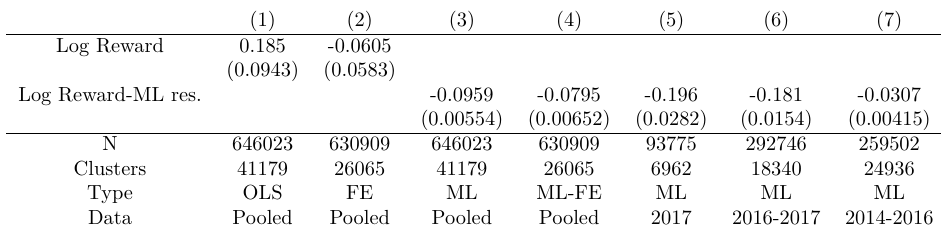

#### 2、对数duration和对数reward的机器学习残差的分箱散点图

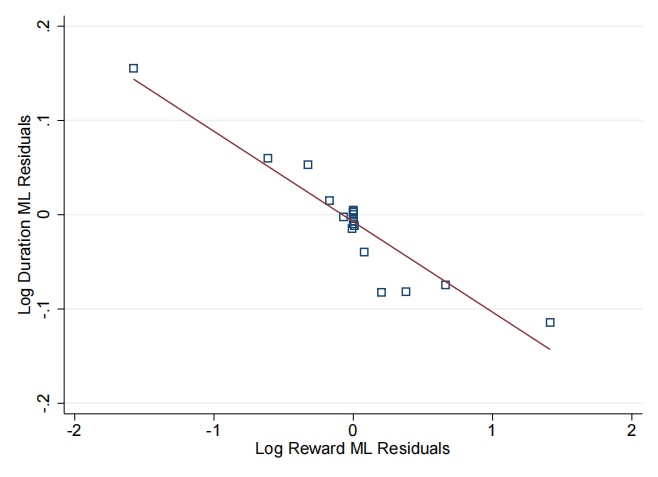

#### 3、Horton、Rand和Zeckhauser实验

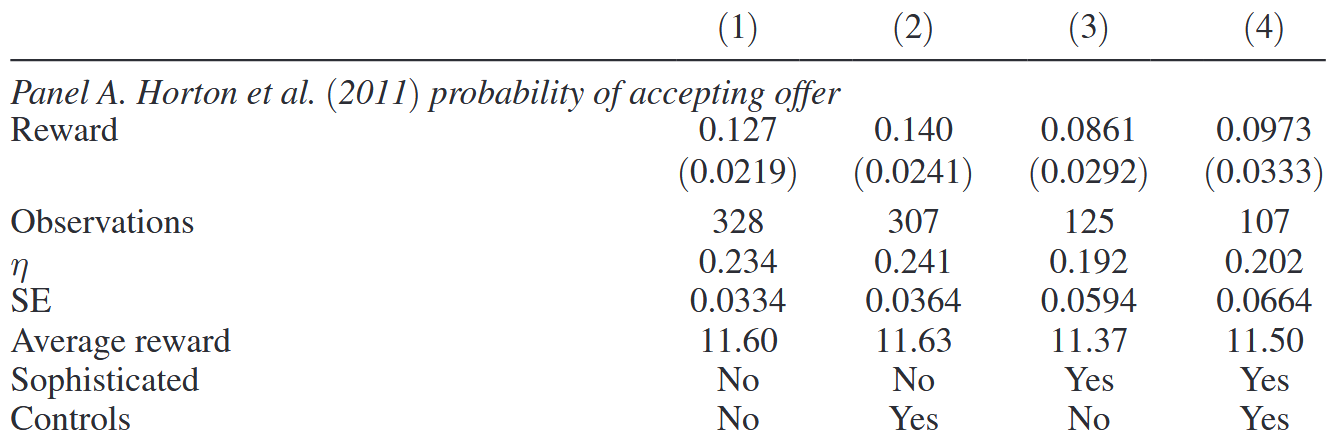

#### 4、Dube、Manning和Naidu实验

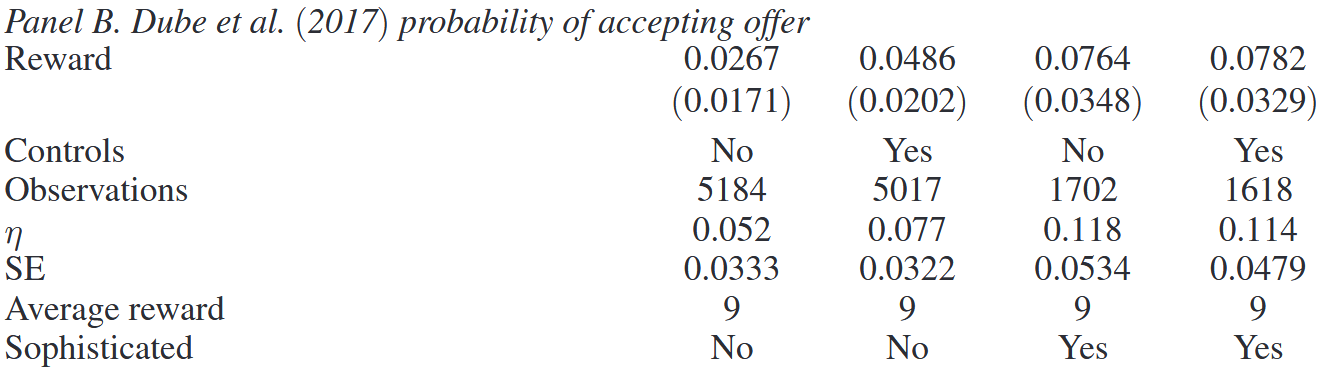

#### 5、简单OLS回归结果

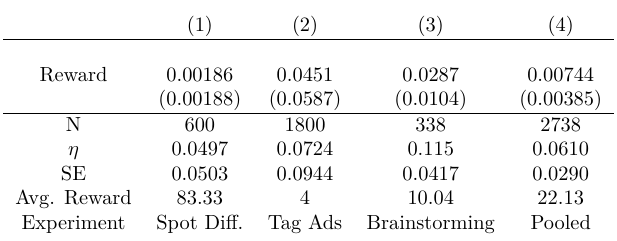

#### 6、DML劳动力弹性与先前实验中的估计值

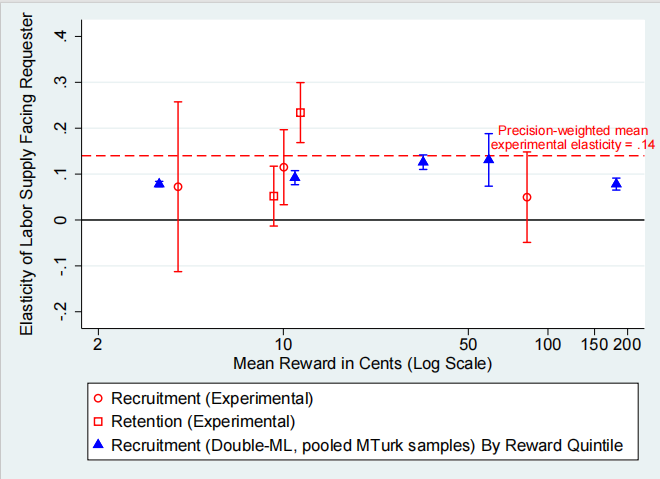